# Аналитика в Яндекс.Афише

Цель - оптимизация маркетинговых затрат.

У нас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Изучим:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент
- когда клиент окупается.

План работы:
- Шаг 1. Загрузка данных и подготовка к анализу
- Шаг 2. Отчеты и метрики
  - Продукт
    - Сколько людей пользуются в день, неделю, месяц?
    - Сколько сессий в день?
    - Сколько длится одна сессия?
    - Как часто люди возвращаются?
  - Продажи
    - Когда люди начинают покупать?
    - Сколько раз покупают за период?
    - Какой средний чек?
    - Сколько денег приносят? (LTV)
  - Маркетинг
    - Сколько денег потратили? Всего / на каждый источник / по времени
    - Сколько стоило привлечение одного покупателя из каждого источника?
    - На сколько окупились расходы? (ROI)
  - Отобразим на графиках, как эти метрики отличаются по устройствам и по рекламным источникам? Как они меняются во времени?
- Шаг 3. Общий вывод

## Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
visits = pd.read_csv('datasets/visits_log.csv')

In [3]:
orders = pd.read_csv('datasets/orders_log.csv')

In [4]:
costs = pd.read_csv('datasets/costs.csv')

In [5]:
display(visits.head())

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


In [6]:
display(orders.head())

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [7]:
display(costs.head())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [8]:
print(visits.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB
None


In [9]:
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB
None


In [10]:
print(costs.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB
None


Переименуем столбцы в датафреймах visits и orders

In [11]:
visits.columns = ['device', 'end_ts', 'source_id', 'start_ts', 'uid']

In [12]:
orders.columns = ['buy_ts', 'revenue', 'uid']

Заменим типы данных в столбцах с датами 

In [13]:
visits['end_ts'] = pd.to_datetime(visits['end_ts'] )

In [14]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])

In [15]:
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

In [16]:
costs['dt'] = pd.to_datetime(costs['dt'])

In [17]:
visits['uid'] = visits['uid'].astype('object')

In [18]:
orders['uid'] = orders['uid'].astype('object')

Проверим данные на дубликаты 

In [19]:
print(visits.duplicated().sum())

0


In [20]:
print(orders.duplicated().sum())

0


In [21]:
print(costs.duplicated().sum())

0


Дубликатов нет. Перейдем к грубым ошибкам в данных

In [22]:
display(visits.loc[visits['start_ts'] > visits['end_ts']])

,device,end_ts,source_id,start_ts,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Перейдем к отчетам и метрикам

## Отчеты и метрики 

### Продукт

Посмотрим, сколько пользователей в день, неделю, месяц

In [24]:
visits['session_year'] = visits['start_ts'].dt.year
visits['session_month'] = visits['start_ts'].astype('datetime64[M]')
visits['session_week'] = visits['start_ts'].dt.isocalendar().week
visits['session_day'] = visits['start_ts'].dt.date

In [25]:
display(visits.head())

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017,2017-07-01,26,2017-07-01
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017,2017-12-01,52,2017-12-27


In [26]:
dau_total = int(visits.groupby('session_day').agg({'uid':'nunique'}).mean())
print('Количество использований в день:', dau_total)

Количество использований в день: 907


Text(0, 0.5, 'Количество посещений')

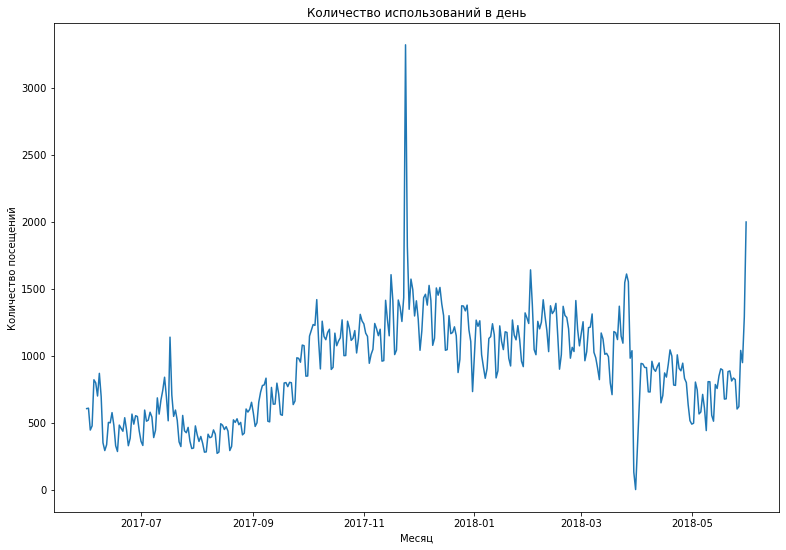

In [27]:
plt.figure()
visits.groupby(['session_day'])['uid'].nunique().plot(figsize = (13,9), title = 'Количество использований в день')
plt.xlabel('Месяц')
plt.ylabel('Количество посещений')

Аномальные количества посещений наблюдаются в декабре (всплеск перед новым годом) и в апреле(резкий упадок)

In [28]:
wau_total = int(visits.groupby(['session_year','session_week']).agg({'uid':'nunique'}).mean())
print('Количество использовний в неделю:', wau_total)

Количество использовний в неделю: 5716


Text(0, 0.5, 'Количество посещений')

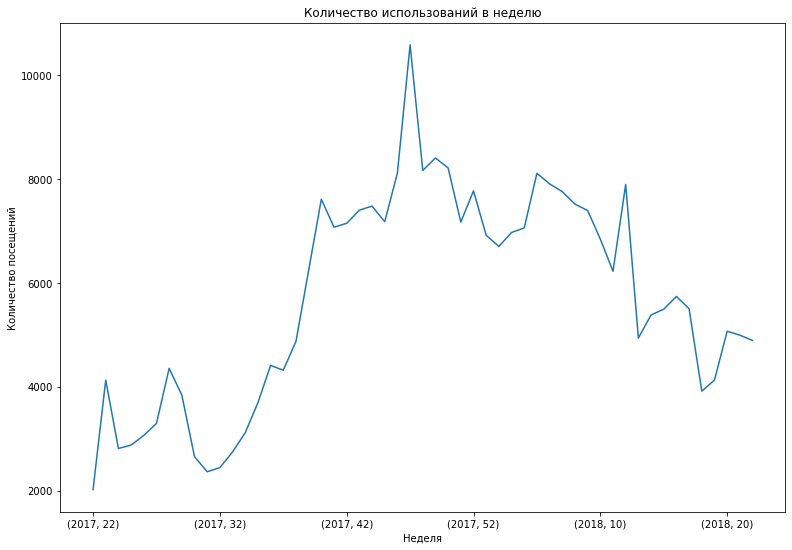

In [29]:
plt.figure()
visits.groupby(['session_year', 'session_week'])['uid'].nunique().plot(figsize = (13,9), title = 'Количество использований в неделю')
plt.xlabel('Неделя')
plt.ylabel('Количество посещений')

In [30]:
mau_total = int(visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean())
print('Количество использований в месяц:', mau_total)

Количество использований в месяц: 23228


Text(0, 0.5, 'Количество посещений')

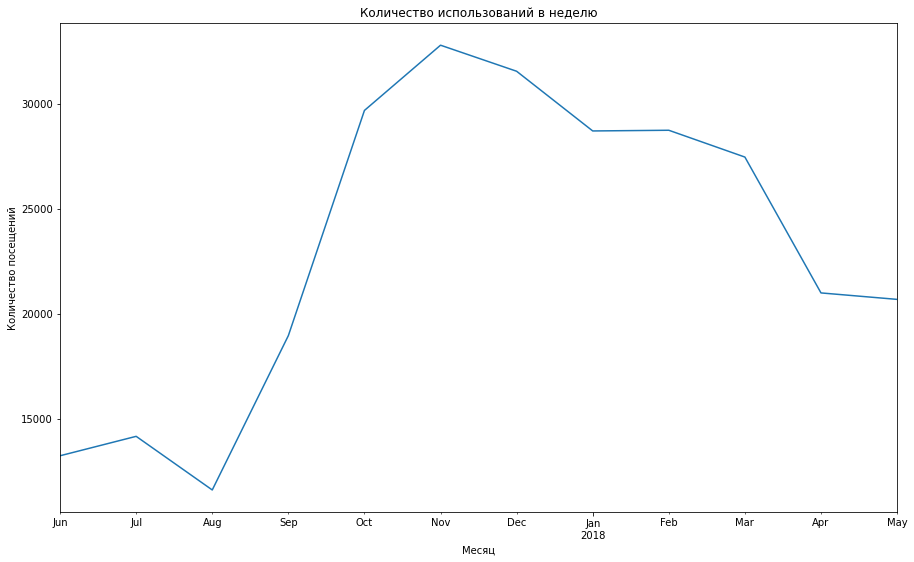

In [31]:
plt.figure()
visits.groupby(['session_month'])['uid'].nunique().plot(figsize = (15,9), title = 'Количество использований в неделю')
plt.xlabel('Месяц')
plt.ylabel('Количество посещений')

Афишей чаще пользуются в холодные месяцы, в летние месяцы посещяемость сильно падает 

Text(0, 0.5, 'Количество посещений')

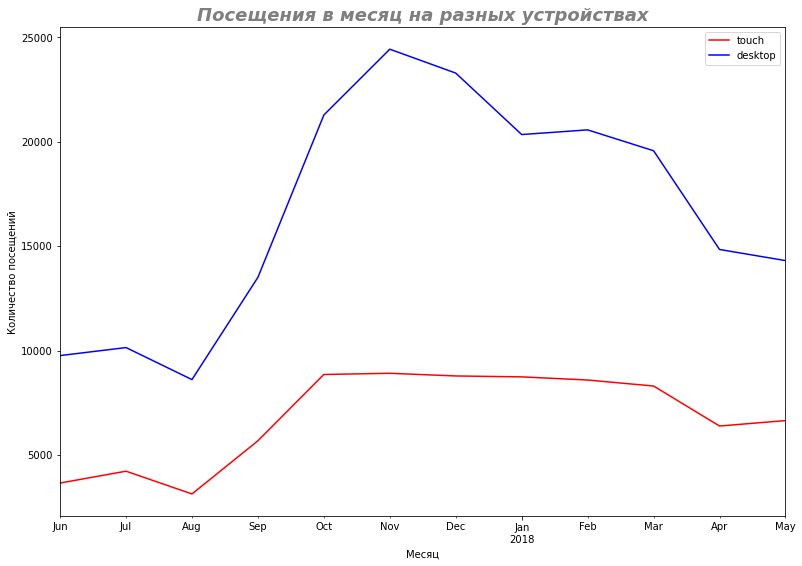

In [32]:
plt.figure(figsize = (13, 9))
plt.title('Посещения в месяц на разных устройствах', alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
visits.loc[visits['device'] == 'touch'].groupby(['session_month'])['uid'].nunique().plot(color = 'r')
visits.loc[visits['device'] == 'desktop'].groupby(['session_month'])['uid'].nunique().plot(color = 'b')
plt.legend(['touch', 'desktop'])
plt.xlabel('Месяц')
plt.ylabel('Количество посещений')

Посещений с ПК заметно больше, чем с мобильных устройств. Тенденция с холодными и теплыми месяцами остается

Text(93.5, 0.5, 'Источник')

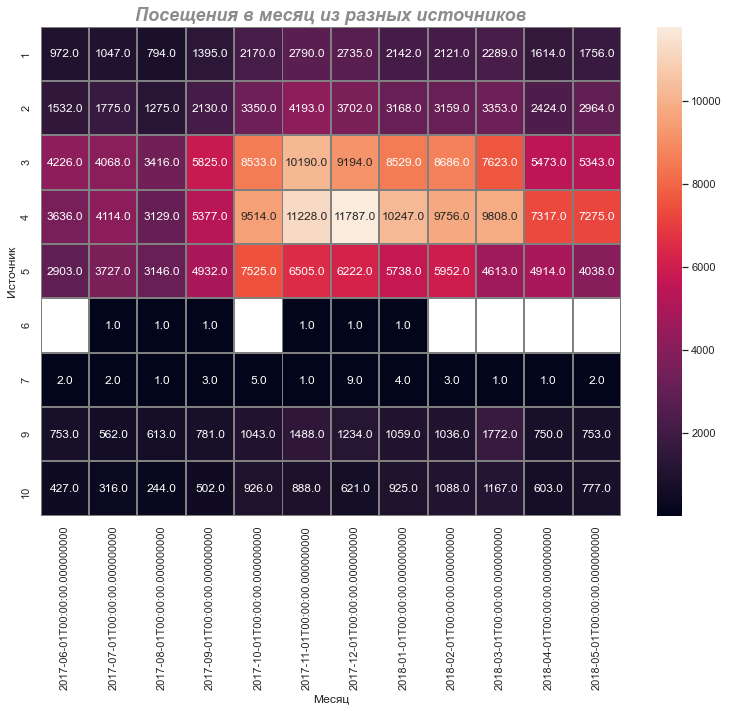

In [33]:
sources_monthly_visits = visits.pivot_table(index = 'source_id', columns = 'session_month', values = 'uid', aggfunc = 'nunique')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Посещения в месяц из разных источников',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(sources_monthly_visits, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.xlabel('Месяц')
plt.ylabel('Источник')

Больше посещений из источников 3, 4, 5. Источний 8 нерабочий, а 6 и 7 почти не приносит пользователей

Теперь посмотрим количество сессий в день 

In [34]:
daily_sessions_per_user =  visits.groupby('session_day').agg({'uid':['count', 'nunique']})
daily_sessions_per_user.columns = ['n_sessions', 'n_users']
daily_sessions_per_user['sess_per_user'] = daily_sessions_per_user['n_sessions'] / daily_sessions_per_user['n_users']
display(daily_sessions_per_user)

,n_sessions,n_users,sess_per_user
session_day,,,
2017-06-01,664,605,1.097521
2017-06-02,658,608,1.082237
2017-06-03,477,445,1.071910
2017-06-04,510,476,1.071429
2017-06-05,893,820,1.089024
...,...,...,...
2018-05-27,672,620,1.083871
2018-05-28,1156,1039,1.112608
2018-05-29,1035,948,1.091772


In [35]:
print('Среднее количество сессий в день:', daily_sessions_per_user['sess_per_user'].mean())

Среднее количество сессий в день: 1.0821696440039723


Теперь посмотрим на продолжительность сессий 

In [36]:
visits['sess_duration'] = (visits['end_ts'] - visits['start_ts']).dt.seconds

In [37]:
visits.loc[visits['sess_duration'] > 3600]['sess_duration'].count()

6284

В датафрейме около 2% строк с сессиями дольше часа. Предлагаю от них избавиться, заодно и от отрицательных сессий

In [38]:
visits = visits.loc[(visits['sess_duration'] < 3600) & (visits['sess_duration'] > 0)]

Text(0.5, 1.0, 'Распределение продолжительности сессий')

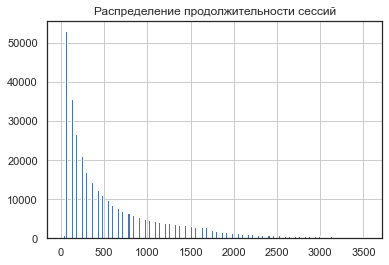

In [39]:
visits['sess_duration'].hist(bins = 150)
plt.title('Распределение продолжительности сессий')

In [40]:
print('Продолжительность сессии:', visits['sess_duration'].mode())

Продолжительность сессии: 0    60
dtype: int64


Самая частая продолжительность сессии - 60 секунд

Text(0, 0.5, 'Средняя продолжительность, сек')

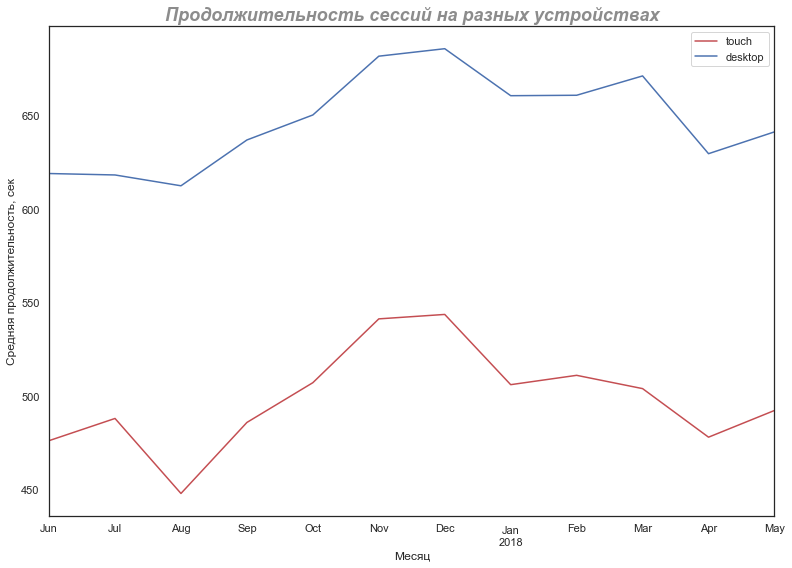

In [41]:
plt.figure(figsize = (13, 9))
plt.title('Продолжительность сессий на разных устройствах', alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
visits.loc[visits['device'] == 'touch'].groupby(['session_month'])['sess_duration'].mean().plot(color = 'r')
visits.loc[visits['device'] == 'desktop'].groupby(['session_month'])['sess_duration'].mean().plot(color = 'b')
plt.legend(['touch', 'desktop'])
plt.xlabel('Месяц')
plt.ylabel('Средняя продолжительность, сек')

На ПК сессии более продолжительны, чем на мобильных устройствах

Text(0, 0.5, 'Средняя продолжительность посещений, сек')

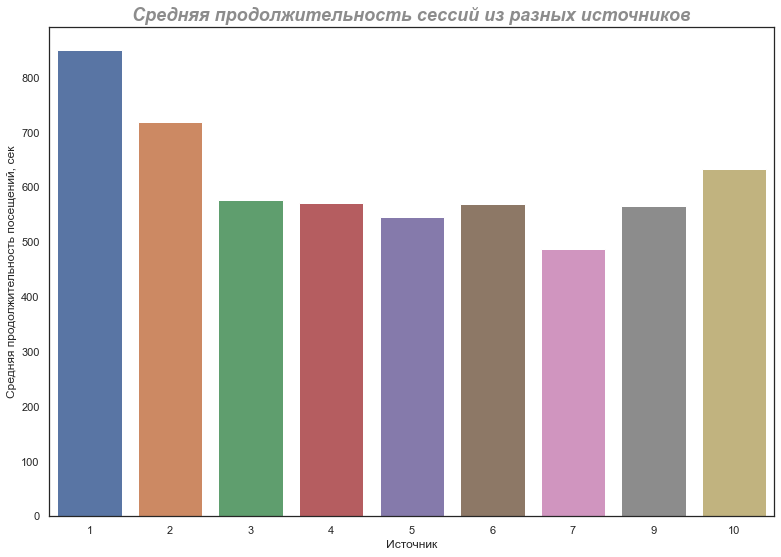

In [42]:

plt.figure(figsize=(13, 9))
plt.title('Средняя продолжительность сессий из разных источников', alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
ax = sns.barplot(x = 'source_id', y='sess_duration', data = visits.pivot_table(index = 'source_id',  values = 'sess_duration', aggfunc = 'mean').reset_index())
plt.xlabel('Источник')
plt.ylabel('Средняя продолжительность посещений, сек')

Из источник 1 самые длительные сессии

Посмотрим, как часто пользователи возвращаются

In [43]:
sticky_wau = dau_total / wau_total * 100
print('Sticky factor за неделю:', sticky_wau)

Sticky factor за неделю: 15.867739678096571


In [44]:
sticky_mau = dau_total / mau_total * 100
print('Sticky factor за месяц:', sticky_mau)

Sticky factor за месяц: 3.9047701050456345


In [45]:
display(visits.head())

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day,sess_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,1680
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,1440
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-01,35,2017-09-03,60
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451,2018,2018-01-01,5,2018-01-30,3360


In [46]:
first_order = visits.groupby('uid')['start_ts'].min().reset_index()
first_order.columns = ['uid', 'first_session_date']

In [47]:
visits = visits.merge(first_order, on = 'uid')

In [48]:

visits['activity_month'] = visits['start_ts'].astype('datetime64[M]')
visits['first_activity_month'] =visits['first_session_date'].astype('datetime64[M]')

In [49]:
visits['cohort_lifetime'] = ((visits['activity_month'] - visits['first_activity_month']) / np.timedelta64(1,'M')).round().astype('int')


In [50]:
cohorts = visits.groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users.columns = ['first_activity_month', 'cohort_users']
cohorts = cohorts.merge(initial_users, on = 'first_activity_month')


In [51]:
cohorts['retention'] = cohorts['uid'] / cohorts['cohort_users']

In [52]:
retention_pivot = cohorts.pivot_table(index = 'first_activity_month', columns = 'cohort_lifetime', values = 'retention', aggfunc = 'sum')
retention_pivot.fillna('')

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_activity_month,,,,,,,,,,,,
2017-06-01,1.0,0.0756025,0.0508245,0.0598732,0.0651163,0.0668922,0.057759,0.0557294,0.0505708,0.0494715,0.0379704,0.0437209
2017-07-01,1.0,0.0540839,0.0497538,0.0554424,0.0562065,0.0461878,0.0436407,0.0436407,0.0376125,0.0272542,0.0269995,
2017-08-01,1.0,0.0734125,0.0597974,0.0594706,0.0472715,0.0408452,0.035726,0.0371419,0.0269034,0.0241804,,
2017-09-01,1.0,0.0824366,0.0672247,0.0489571,0.0377308,0.0368673,0.0346752,0.0228511,0.0225854,,,
2017-10-01,1.0,0.076808,0.0503932,0.0371004,0.0332108,0.0309455,0.0208583,0.0194478,,,,
2017-11-01,1.0,0.0767668,0.0421831,0.0375097,0.0323079,0.021376,0.0201975,,,,,
2017-12-01,1.0,0.0544546,0.0361277,0.0298579,0.0193353,0.0175816,,,,,,
2018-01-01,1.0,0.0572002,0.0375789,0.0242208,0.019083,,,,,,,
2018-02-01,1.0,0.0551604,0.024372,0.0192489,,,,,,,,


Text(93.49999999999999, 0.5, 'Месяц первой покупки')

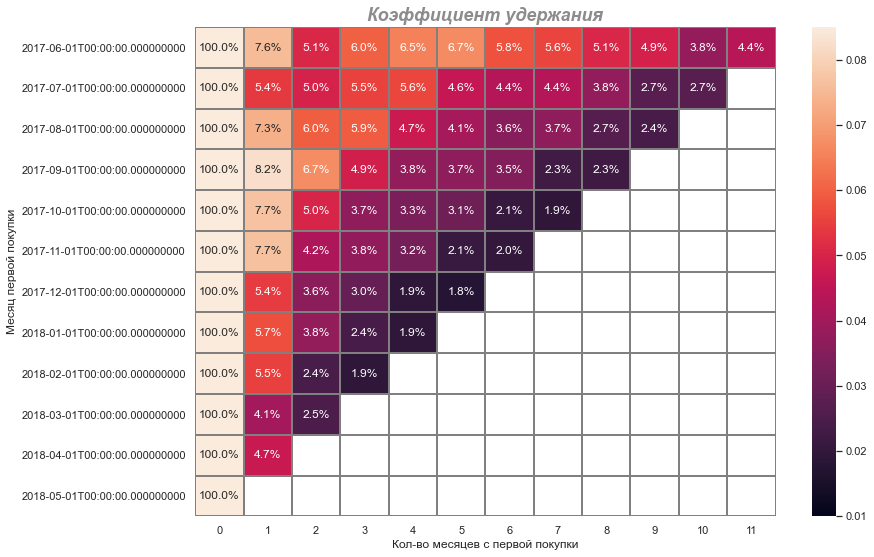

In [53]:


sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Коэффициент удержания',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0.01, vmax = 0.085)
plt.xlabel('Кол-во месяцев с первой покупки')
plt.ylabel('Месяц первой покупки')

Пользователи редко возвращаются из месяца в месяц 

In [54]:
cohorts_d = visits.loc[visits['device'] == 'desktop'].groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_d = cohorts_d[cohorts_d['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_d.columns = ['first_activity_month', 'cohort_users']
cohorts_d = cohorts_d.merge(initial_users_d, on = 'first_activity_month')
cohorts_d['retention'] = cohorts_d['uid'] / cohorts_d['cohort_users']


In [55]:
cohorts_t = visits.loc[visits['device'] == 'touch'].groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_t = cohorts_t[cohorts_t['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
initial_users_t.columns = ['first_activity_month', 'cohort_users']
cohorts_t = cohorts_t.merge(initial_users_t, on = 'first_activity_month')
cohorts_t['retention'] = cohorts_t['uid'] / cohorts_t['cohort_users']

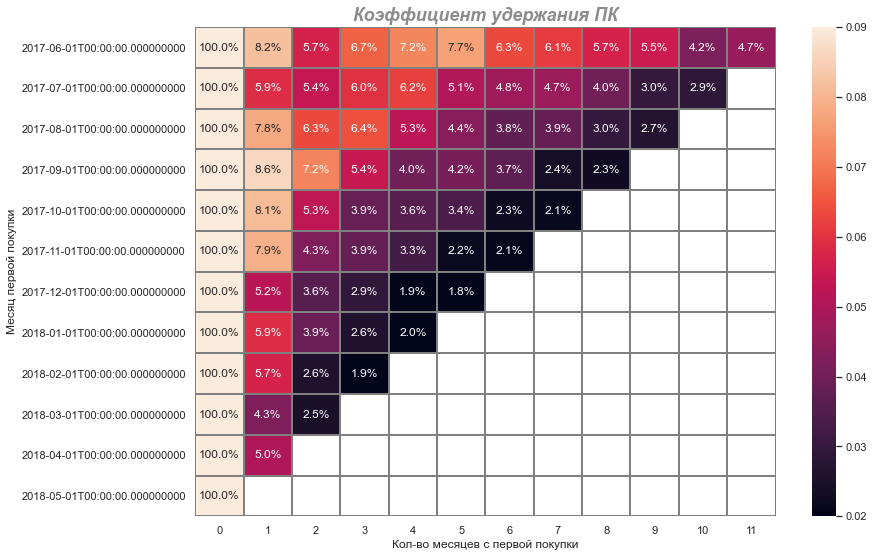

Text(93.49999999999999, 0.5, 'Месяц первой покупки')

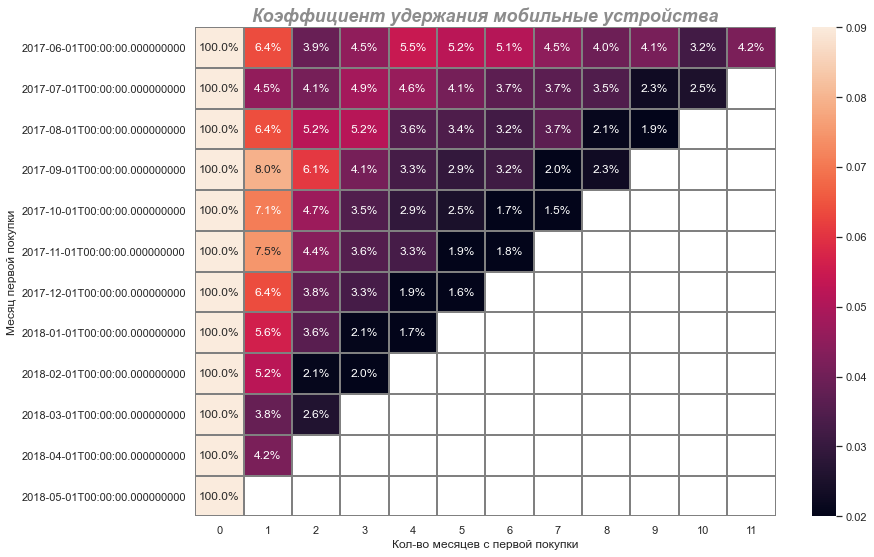

In [56]:
retention_pivot_desktop = cohorts_d.pivot_table(index = 'first_activity_month', columns = 'cohort_lifetime', values = 'retention', aggfunc = 'sum')
retention_pivot.fillna('')
retention_pivot_touch = cohorts_t.pivot_table(index = 'first_activity_month', columns = 'cohort_lifetime', values = 'retention', aggfunc = 'sum')
retention_pivot.fillna('')
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Коэффициент удержания ПК',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(retention_pivot_desktop, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0.02, vmax = 0.09)
plt.xlabel('Кол-во месяцев с первой покупки')
plt.ylabel('Месяц первой покупки')
plt.show()
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Коэффициент удержания мобильные устройства',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(retention_pivot_touch, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0.02, vmax = 0.09)
plt.xlabel('Кол-во месяцев с первой покупки')
plt.ylabel('Месяц первой покупки')


RR примерно одинаковый для пользователей ПК и моб устройств

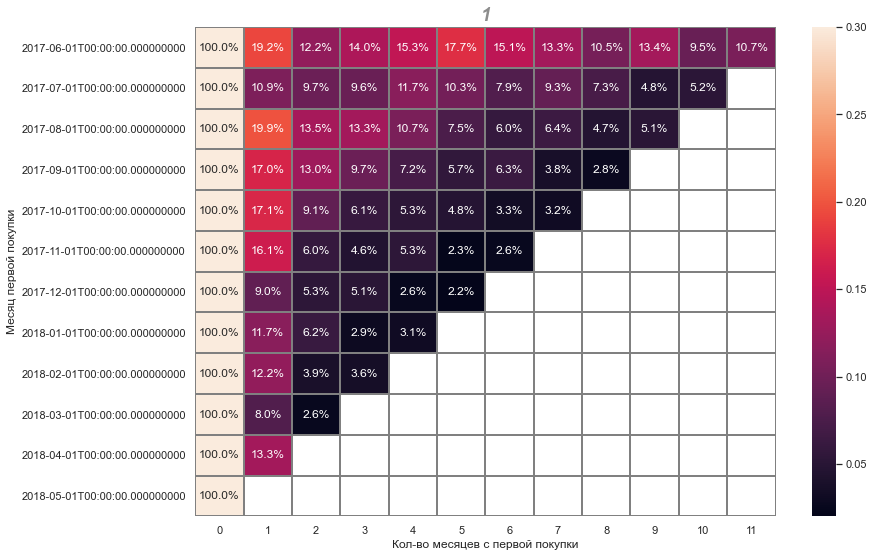

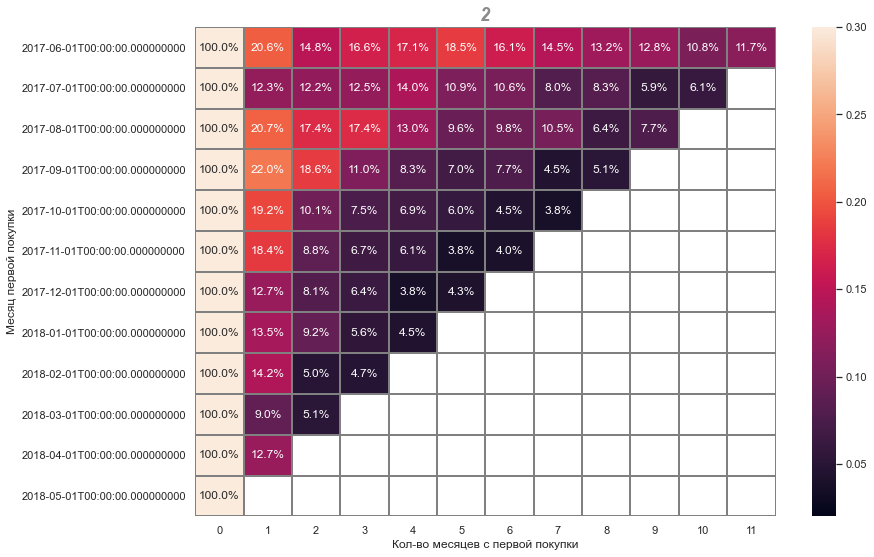

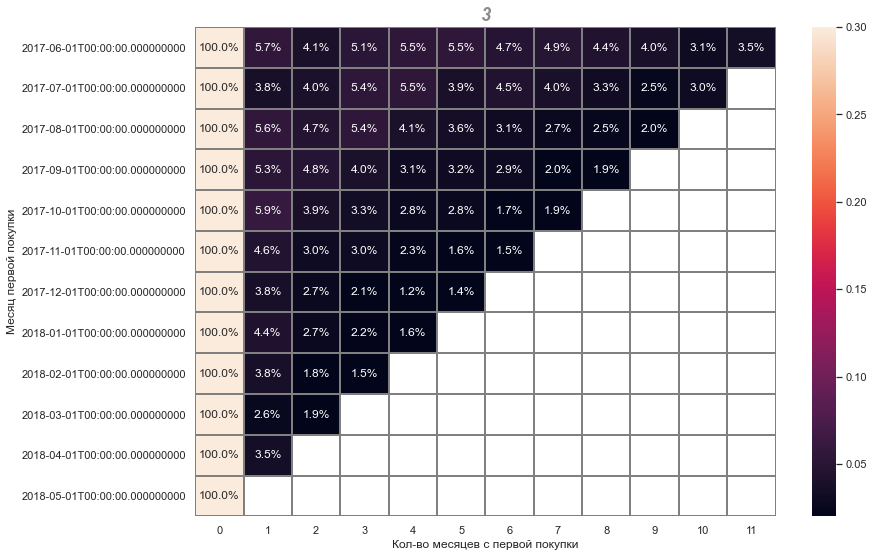

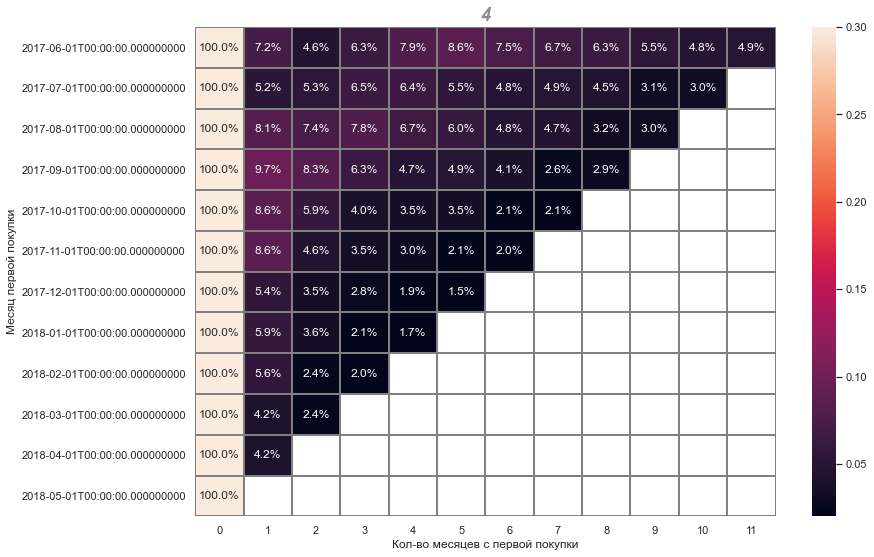

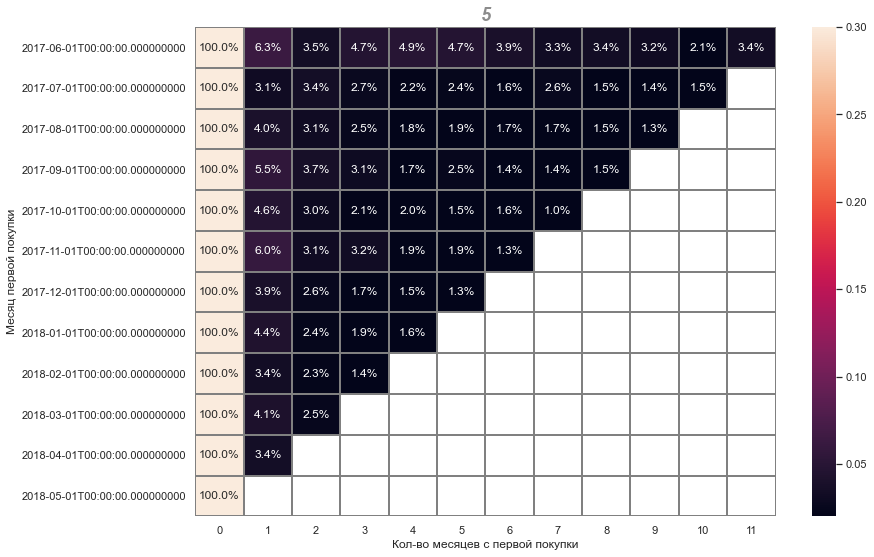

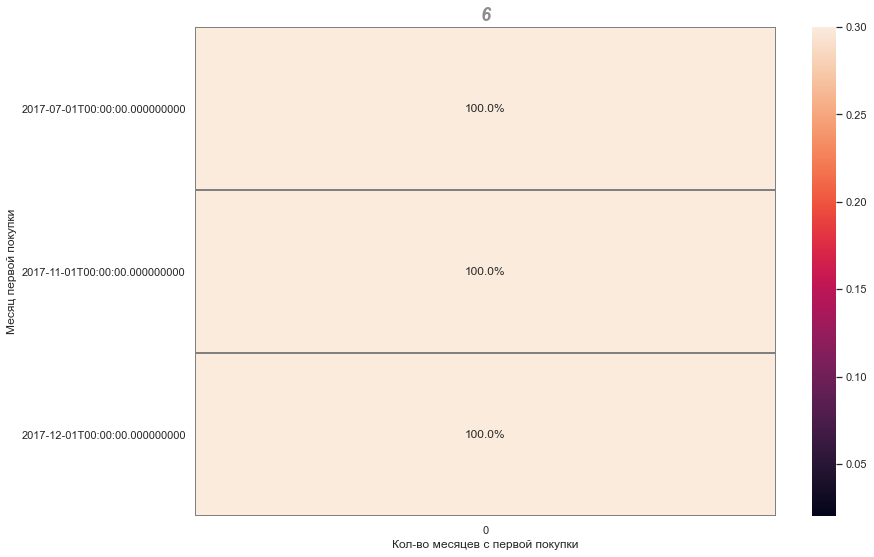

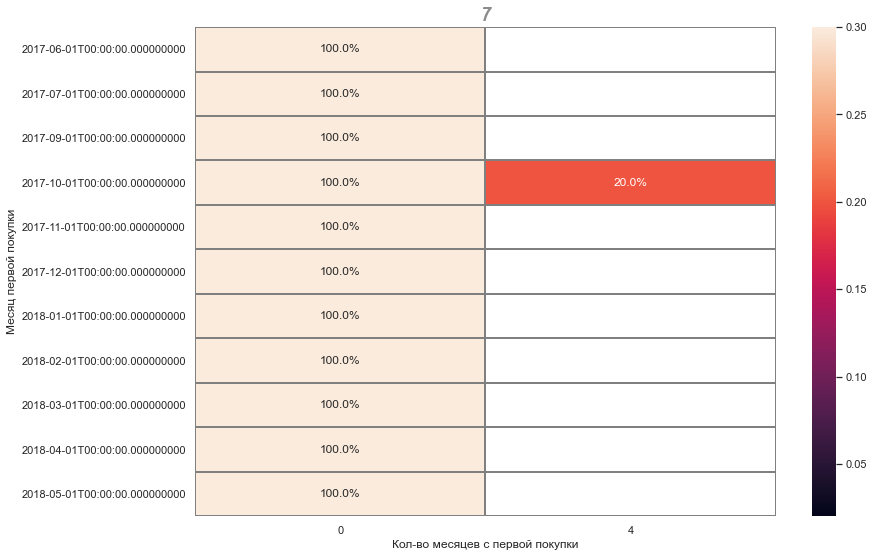

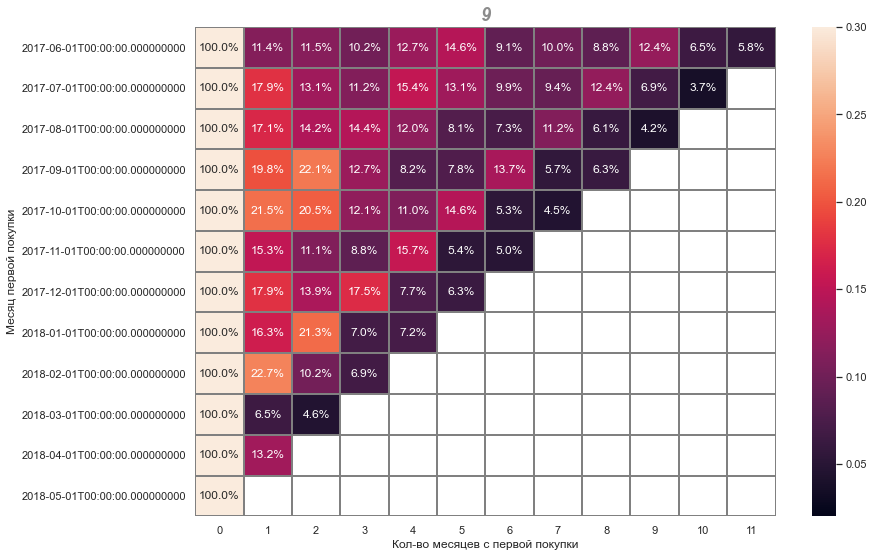

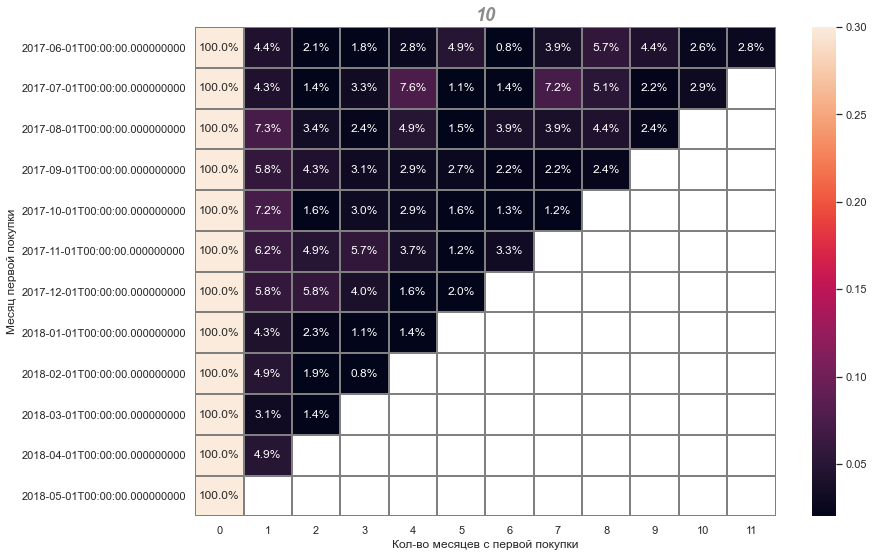

In [57]:
i = 0
for i in range (len(visits['source_id'].unique()) - 2):
    cohorts_source = visits.loc[(visits['source_id'] == i+1)].groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
    initial_users_s = cohorts_source[cohorts_source['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
    initial_users_s.columns = ['first_activity_month', 'cohort_users']
    cohorts_source = cohorts_source.merge(initial_users_s, on = 'first_activity_month')
    cohorts_source['retention'] = cohorts_source['uid'] / cohorts_source['cohort_users']
    retention_pivot_s = cohorts_source.pivot_table(index = 'first_activity_month', columns = 'cohort_lifetime', values = 'retention', aggfunc = 'sum')
    retention_pivot_s.fillna('')
    
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title(i+1,  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
    sns.heatmap(retention_pivot_s, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0.02, vmax = 0.3)
    plt.xlabel('Кол-во месяцев с первой покупки')
    plt.ylabel('Месяц первой покупки')
    plt.show()
    
    j = 9
for j in range (9, 11):
    cohorts_source = visits.loc[(visits['source_id'] == j)].groupby(['first_activity_month', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
    initial_users_s = cohorts_source[cohorts_source['cohort_lifetime'] == 0][['first_activity_month', 'uid']]
    initial_users_s.columns = ['first_activity_month', 'cohort_users']
    cohorts_source = cohorts_source.merge(initial_users_s, on = 'first_activity_month')
    cohorts_source['retention'] = cohorts_source['uid'] / cohorts_source['cohort_users']
    retention_pivot_s = cohorts_source.pivot_table(index = 'first_activity_month', columns = 'cohort_lifetime', values = 'retention', aggfunc = 'sum')
    retention_pivot_s.fillna('')
    
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title(j,  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
    sns.heatmap(retention_pivot_s, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin = 0.02, vmax = 0.3)
    plt.xlabel('Кол-во месяцев с первой покупки')
    plt.ylabel('Месяц первой покупки')
    plt.show()




Хороший RR из источников 1, 2 и 9; источники 6, 7 почти не работают, 8 не используется

### Продажи 

Ответим на вопрос - когда люди начинают покупать? 


Выясним, сколько времени прошло между началом сессии и совершением заказа

In [58]:
display(orders.head())

,buy_ts,revenue,uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


In [59]:
orders['order_date'] = orders['buy_ts'].astype('datetime64[D]')

In [60]:
display(visits.head())

,device,end_ts,source_id,start_ts,uid,session_year,session_month,session_week,session_day,sess_duration,first_session_date,activity_month,first_activity_month,cohort_lifetime
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017,2017-12-01,51,2017-12-20,1080,2017-12-20 17:20:00,2017-12-01,2017-12-01,0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018,2018-02-01,8,2018-02-19,1680,2018-02-19 16:53:00,2018-02-01,2018-02-01,0
2,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018,2018-05-01,20,2018-05-20,1440,2018-03-09 20:05:00,2018-05-01,2018-03-01,2
3,desktop,2018-03-09 20:33:00,4,2018-03-09 20:05:00,16174680259334210214,2018,2018-03-01,10,2018-03-09,1680,2018-03-09 20:05:00,2018-03-01,2018-03-01,0
4,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387,2017,2017-09-01,35,2017-09-03,60,2017-09-03 21:35:00,2017-09-01,2017-09-01,0


In [61]:
first_ord = orders.groupby('uid')['buy_ts'].min().reset_index()
first_ord.columns = ['uid', 'first_order_date']
orders = orders.merge(first_ord, on = 'uid')

In [62]:
print(first_order.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205790 entries, 0 to 205789
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   uid                 205790 non-null  uint64        
 1   first_session_date  205790 non-null  datetime64[ns]
dtypes: datetime64[ns](1), uint64(1)
memory usage: 3.1 MB
None


In [63]:
print(first_ord.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36523 entries, 0 to 36522
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   uid               36523 non-null  uint64        
 1   first_order_date  36523 non-null  datetime64[ns]
dtypes: datetime64[ns](1), uint64(1)
memory usage: 570.8 KB
None


In [64]:
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50415 entries, 0 to 50414
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   buy_ts            50415 non-null  datetime64[ns]
 1   revenue           50415 non-null  float64       
 2   uid               50415 non-null  object        
 3   order_date        50415 non-null  datetime64[ns]
 4   first_order_date  50415 non-null  datetime64[ns]
dtypes: datetime64[ns](3), float64(1), object(1)
memory usage: 2.3+ MB
None


In [65]:
first_visits_plus_orders = first_ord.merge(first_order, on = 'uid')

In [66]:
print(first_visits_plus_orders.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35509 entries, 0 to 35508
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   uid                 35509 non-null  uint64        
 1   first_order_date    35509 non-null  datetime64[ns]
 2   first_session_date  35509 non-null  datetime64[ns]
dtypes: datetime64[ns](2), uint64(1)
memory usage: 1.1 MB
None


In [67]:
first_visits_plus_orders['order_delta'] = (first_visits_plus_orders['first_order_date'] - first_visits_plus_orders['first_session_date']).dt.seconds

<AxesSubplot:>

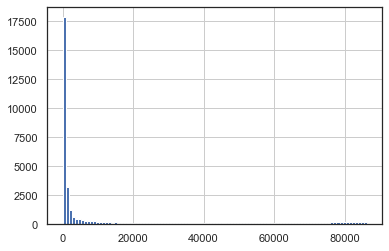

In [68]:
first_visits_plus_orders['order_delta'].hist(bins=100)

In [69]:
print(first_visits_plus_orders['order_delta'].mode())

0    60
dtype: int64


В среднем покупка происходит через 60 секунд после захода на сайт 

Сколько раз покупают за период? Возьмем за период 1 месяц 

In [70]:
orders['activity_month'] = orders['buy_ts'].astype('datetime64[M]')

In [71]:
orders_per_month = orders.pivot_table(index = 'activity_month', values = 'revenue', aggfunc = 'count')
orders_per_month.columns = ['n_orders']

In [72]:
display(orders_per_month)

,n_orders
activity_month,
2017-06-01,2354
2017-07-01,2363
2017-08-01,1807
2017-09-01,3387
2017-10-01,5679
2017-11-01,5659
2017-12-01,6218
2018-01-01,4721
2018-02-01,5281


Text(0, 0.5, 'Количество покупок')

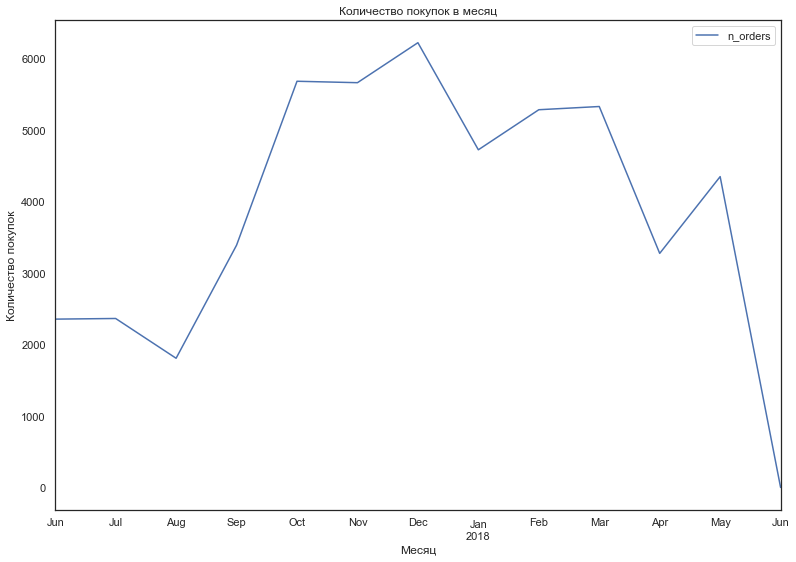

In [73]:
orders_per_month.plot(title = 'Количество покупок в месяц', figsize = (13, 9))
plt.xlabel('Месяц')
plt.ylabel('Количество покупок')

In [74]:
print(orders_per_month['n_orders'].mean())

3878.076923076923


В среднем пользователи делают 3878 заказа в месяц 

In [75]:
users = visits.groupby('uid').agg({'source_id':'first', 'device':'first', 'start_ts':'first'}).reset_index()
display(users.head())

,uid,source_id,device,start_ts
0,11863502262781,3,touch,2018-03-01 17:27:00
1,49537067089222,2,touch,2018-02-06 15:55:00
2,297729379853735,3,desktop,2017-06-07 18:47:00
3,313578113262317,2,desktop,2018-03-11 17:23:00
4,325320750514679,5,desktop,2017-09-30 14:29:00


In [76]:
orders = orders.merge(users, on = 'uid')
print(orders.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49322 entries, 0 to 49321
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   buy_ts            49322 non-null  datetime64[ns]
 1   revenue           49322 non-null  float64       
 2   uid               49322 non-null  object        
 3   order_date        49322 non-null  datetime64[ns]
 4   first_order_date  49322 non-null  datetime64[ns]
 5   activity_month    49322 non-null  datetime64[ns]
 6   source_id         49322 non-null  int64         
 7   device            49322 non-null  object        
 8   start_ts          49322 non-null  datetime64[ns]
dtypes: datetime64[ns](5), float64(1), int64(1), object(2)
memory usage: 3.8+ MB
None


Text(0, 0.5, 'Количество заказов')

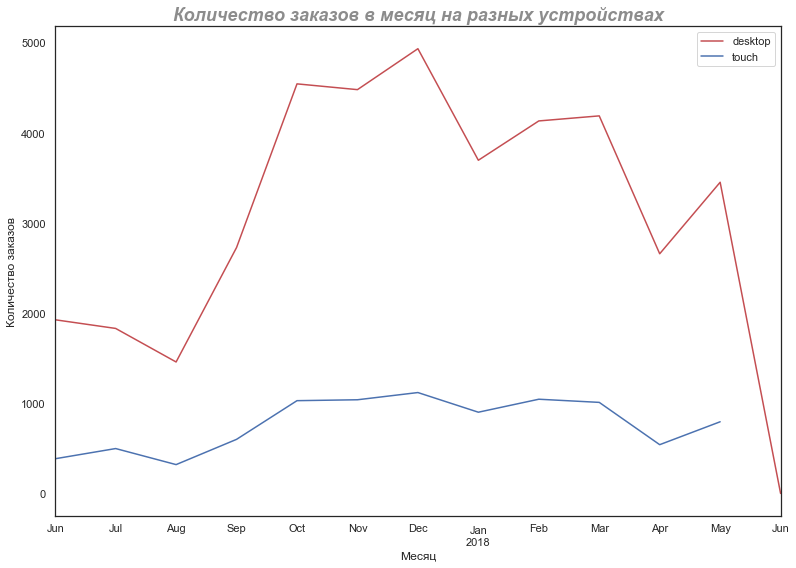

In [77]:
plt.figure(figsize = (13, 9))
plt.title('Количество заказов в месяц на разных устройствах', alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
orders.loc[orders['device'] == 'desktop'].groupby('activity_month').agg({'uid':'count'})['uid'].plot(color = 'r')
orders.loc[orders['device'] == 'touch'].groupby('activity_month').agg({'uid':'count'})['uid'].plot(color = 'b')
plt.legend(['desktop', 'touch'])
plt.xlabel('Месяц')
plt.ylabel('Количество заказов')


С ПК заказов больше, чем с моб устройств

Text(93.49999999999999, 0.5, 'Месяц')

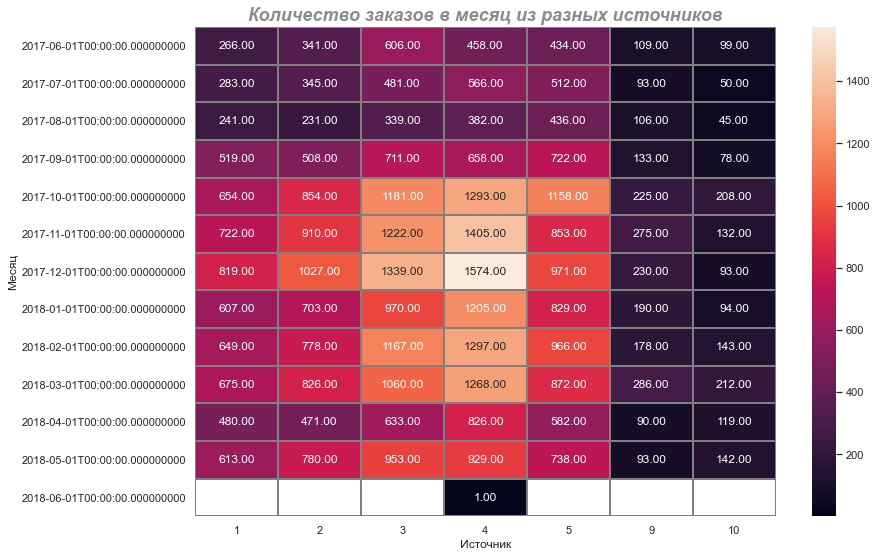

In [78]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Количество заказов в месяц из разных источников',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(orders.pivot_table(index = 'activity_month', columns = 'source_id', values = 'uid', aggfunc = 'count'), annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel('Источник')
plt.ylabel('Месяц')

Больше всего заказов из источников 3, 4 и 5

Посчитаем средний чек за месяц

In [79]:
revenue_per_month = orders.pivot_table(index = 'activity_month', values = 'revenue', aggfunc = 'sum')
revenue_per_month = revenue_per_month.join(orders_per_month)
revenue_per_month['revenue_per_order'] = revenue_per_month['revenue'] / revenue_per_month['n_orders']

In [80]:
display(revenue_per_month)

,revenue,n_orders,revenue_per_order
activity_month,,,
2017-06-01,9355.52,2354,3.974308
2017-07-01,12436.53,2363,5.263026
2017-08-01,8623.48,1807,4.772263
2017-09-01,18046.56,3387,5.328184
2017-10-01,27590.03,5679,4.858255
2017-11-01,26375.55,5659,4.660815
2017-12-01,35615.93,6218,5.727876
2018-01-01,18898.30,4721,4.003029
2018-02-01,25119.49,5281,4.756578


Text(0, 0.5, 'Средний чек')

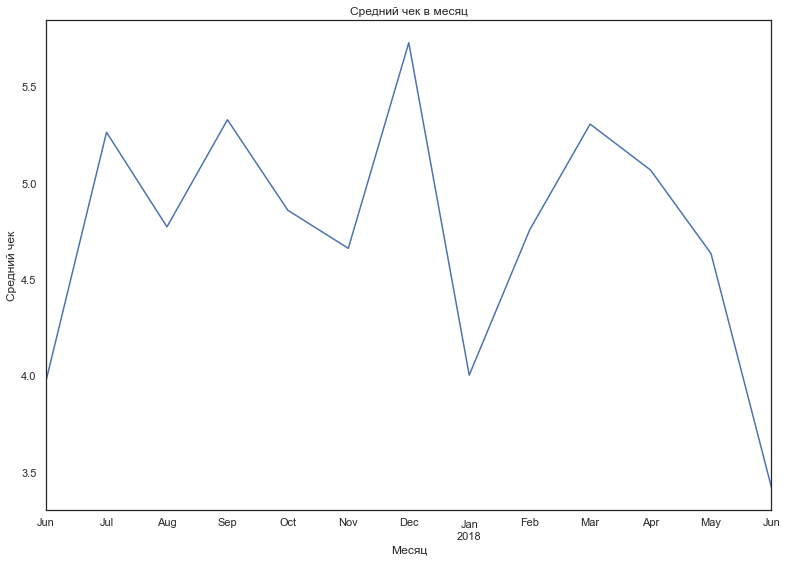

In [81]:
revenue_per_month['revenue_per_order'].plot(title = 'Средний чек в месяц', figsize = (13, 9))
plt.xlabel('Месяц')
plt.ylabel('Средний чек')

In [82]:
print('Средний чек', revenue_per_month['revenue_per_order'].mean())

Средний чек 4.7515691374884765


In [83]:

revenue_per_month_device = orders.pivot_table(
    index = 'activity_month', columns = 'device', values = 'revenue', aggfunc = 'sum') / orders.pivot_table(
    index = 'activity_month', columns = 'device', values = 'revenue', aggfunc = 'count')

Text(0, 0.5, 'Средний чек')

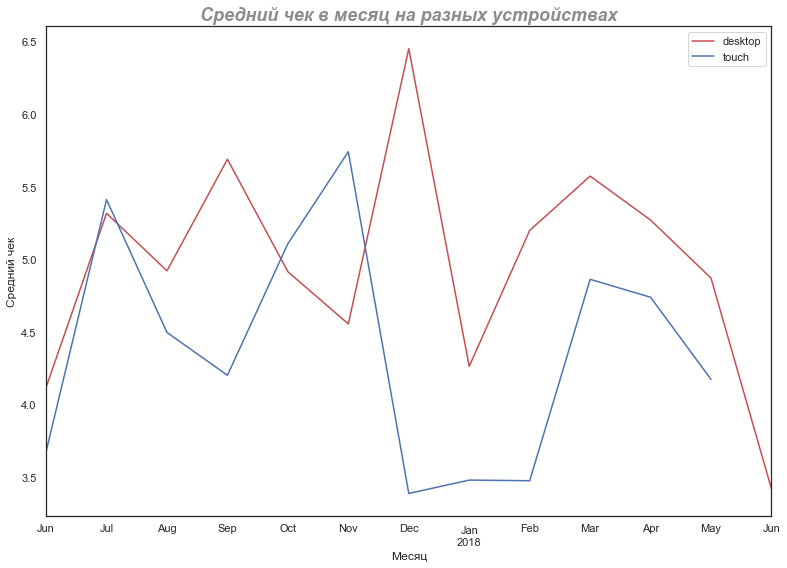

In [84]:
plt.figure(figsize = (13, 9))
plt.title('Средний чек в месяц на разных устройствах', alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
revenue_per_month_device['desktop'].plot(color = 'r')
revenue_per_month_device['touch'].plot(color = 'b')
plt.legend(['desktop', 'touch'])
plt.xlabel('Месяц')
plt.ylabel('Средний чек')

Средний чек с ПК почти всегда выше, чем с мобильных устройств

In [85]:
revenue_per_month_source = orders.pivot_table(
    index = 'activity_month', columns = 'source_id', values = 'revenue', aggfunc = 'sum') / orders.pivot_table(
    index = 'activity_month', columns = 'source_id', values = 'revenue', aggfunc = 'count')

Text(93.49999999999999, 0.5, 'месяц')

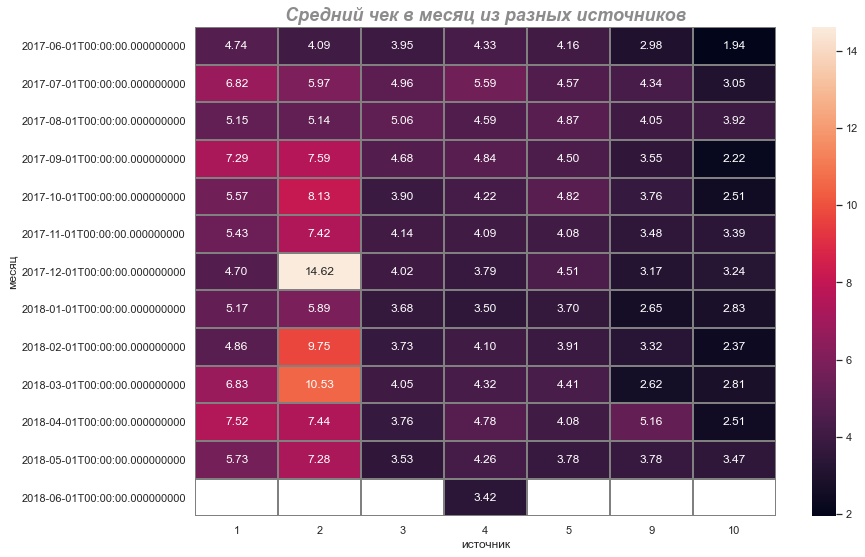

In [86]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Средний чек в месяц из разных источников',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(revenue_per_month_source , annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.xlabel('источник')
plt.ylabel('месяц')

Большие средние чеки из источников 1 и 2

Теперть рассчитаем LTV

In [87]:
display(orders.head())

,buy_ts,revenue,uid,order_date,first_order_date,activity_month,source_id,device,start_ts
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,1,desktop,2017-06-01 00:09:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2,desktop,2017-06-01 00:14:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2,desktop,2017-06-01 00:25:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2,desktop,2017-06-01 00:14:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,3,desktop,2017-06-01 07:31:00


In [88]:
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')
orders['cohort_lifetime'] = ((orders['activity_month'] - orders['first_order_month']) / np.timedelta64(1, 'M')).round().astype('int')

In [89]:

cohorts_orders_count = orders.groupby('first_order_month').agg({'uid':'nunique'})


In [90]:
cohorts_orders_count

,uid
first_order_month,
2017-06-01,1983
2017-07-01,1891
2017-08-01,1345
2017-09-01,2526
2017-10-01,4238
2017-11-01,3958
2017-12-01,4229
2018-01-01,3257
2018-02-01,3558


In [91]:
cohorts_orders_sum = orders.pivot_table(index = 'first_order_month', values = 'revenue', columns = 'cohort_lifetime', aggfunc = 'sum')


In [92]:
i = 0
for i in range(0, 12):
    cohorts_orders_sum[i] = cohorts_orders_sum[i] / cohorts_orders_count['uid'] 
    

In [93]:
ltv = cohorts_orders_sum.cumsum(axis=1)
    

In [94]:

display(ltv)

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_order_month,,,,,,,,,,,,
2017-06-01,4.717862,5.212980,5.659445,6.633374,7.676531,8.426868,9.396480,9.989803,10.554175,11.172184,11.754967,12.017005
2017-07-01,6.057488,6.398371,7.030190,7.392332,7.572115,7.730804,7.853046,7.997266,8.159286,8.308921,8.467229,NaN
2017-08-01,5.274000,5.754766,6.221770,6.620320,7.123554,7.412364,7.626944,8.039219,8.336862,8.528335,NaN,NaN
2017-09-01,5.650776,6.792696,7.324968,11.387328,11.795883,12.457039,13.171746,13.420190,13.608203,NaN,NaN,NaN
2017-10-01,5.031626,5.565720,5.761720,5.921350,6.076557,6.199816,6.286673,6.404922,NaN,NaN,NaN,NaN
2017-11-01,5.155028,5.562835,5.761713,6.096764,6.249376,6.304929,6.423428,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.731613,5.001468,5.954907,7.058974,7.383299,7.733656,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,4.134243,4.439500,4.754618,4.901732,4.966663,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,4.148038,4.433328,4.513895,4.569452,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [95]:
print(ltv.mean())

cohort_lifetime
0      4.804761
1      5.412111
2      5.844986
3      6.731292
4      7.355497
5      8.037925
6      8.459720
7      9.170280
8     10.164632
9      9.336480
10    10.111098
11    12.017005
dtype: float64


Text(93.49999999999999, 0.5, 'Месяц первого заказа')

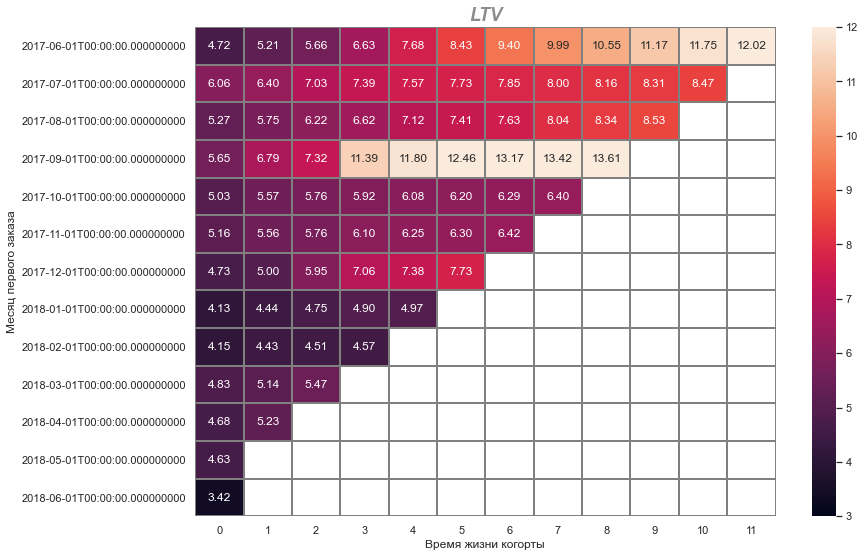

In [96]:
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('LTV',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(ltv, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin = 3, vmax = 12)
plt.xlabel('Время жизни когорты')
plt.ylabel('Месяц первого заказа')

In [97]:
cohorts_orders_count_d = orders.groupby(['first_order_month','device']).agg({'uid':'nunique'})

In [98]:
cohorts_orders_sum_d = orders.pivot_table(index = ['first_order_month','device'], values = 'revenue', columns = 'cohort_lifetime', aggfunc = 'sum')


In [99]:
for i in range(0, 12):
    cohorts_orders_sum_d[i] = cohorts_orders_sum_d[i] / cohorts_orders_count_d['uid']

In [100]:
ltv_device = cohorts_orders_sum_d.cumsum(axis=1)
display(ltv_device)

cohort_lifetime                  0         1         2          3          4   \
first_order_month device                                                        
2017-06-01        desktop  4.821695  5.340978  5.848779   6.993931   7.979830   
                  touch    4.210712  4.587804  4.734688   4.872315   6.195134   
2017-07-01        desktop  5.988840  6.363034  7.159622   7.564504   7.751800   
                  touch    6.307010  6.526814  6.559730   6.766520   6.918995   
2017-08-01        desktop  5.325869  5.883082  6.433891   6.887157   7.489025   
                  touch    5.055465  5.214147  5.328062   5.496085   5.583760   
2017-09-01        desktop  5.874660  6.884814  7.381155  12.436331  12.941373   
                  touch    4.763595  6.427662  7.102318   7.230472   7.256680   
2017-10-01        desktop  5.060666  5.529470  5.744441   5.920235   6.094151   
                  touch    4.904084  5.724924  5.837608   5.926247   5.999288   
2017-11-01        desktop  4.871587  5.347630  5.564734   5.959186   6.127132   
                  touch    6.416846  6.520882  6.638623   6.709229   6.793581   
2017-12-01        desktop  4.932483  5.232122  6.407514   7.766338   8.163494   
                  touch    3.928369  4.079125  4.145012   4.230355   4.263440   
2018-01-01        desktop  4.161738  4.517498  4.887219   5.057983   5.129911   
                  touch    4.029853  4.143358  4.251163   4.308483   4.346848   
2018-02-01        desktop  4.169217  4.458663  4.552514   4.617315        NaN   
                  touch    4.074787  4.345702  4.380326   4.403910        NaN   
2018-03-01        desktop  4.562687  4.758961  5.090070        NaN        NaN   
                  touch    5.853780  6.602102  6.907560        NaN        NaN   
2018-04-01        desktop  4.742209  5.390457       NaN        NaN        NaN   
                  touch    4.421937  4.537215       NaN        NaN        NaN   
2018-05-01        desktop  4.758092       NaN       NaN        NaN        NaN   
                  touch    4.134183       NaN       NaN        NaN        NaN   
2018-06-01        desktop  3.420000       NaN       NaN        NaN        NaN   

cohort_lifetime                   5          6          7          8   \
first_order_month device                                                
2017-06-01        desktop   8.751385   9.821154  10.525705  11.178311   
                  touch     6.841840   7.322255   7.372315   7.505727   
2017-07-01        desktop   7.915219   8.054241   8.217788   8.397363   
                  touch     7.060490   7.121740   7.195711   7.293922   
2017-08-01        desktop   7.786357   8.017351   8.500046   8.852815   
                  touch     5.836667   5.982093   6.097674   6.163062   
2017-09-01        desktop  13.754422  14.611349  14.917219  15.140040   
                  touch     7.315933   7.467073   7.487957   7.538035   
2017-10-01        desktop   6.216819   6.317213   6.431448        NaN   
                  touch     6.125140   6.152545   6.288422        NaN   
2017-11-01        desktop   6.191832   6.328973        NaN        NaN   
                  touch     6.808416   6.843926        NaN        NaN   
2017-12-01        desktop   8.592861        NaN        NaN        NaN   
                  touch     4.297849        NaN        NaN        NaN   
2018-01-01        desktop        NaN        NaN        NaN        NaN   
                  touch          NaN        NaN        NaN        NaN   
2018-02-01        desktop        NaN        NaN        NaN        NaN   
                  touch          NaN        NaN        NaN        NaN   
2018-03-01        desktop        NaN        NaN        NaN        NaN   
                  touch          NaN        NaN        NaN        NaN   
2018-04-01        desktop        NaN        NaN        NaN        NaN   
                  touch          NaN        NaN        NaN        NaN   
2018-05-01        desktop        NaN        NaN        NaN  

Text(111.45312499999999, 0.5, 'Месяц первого заказа')

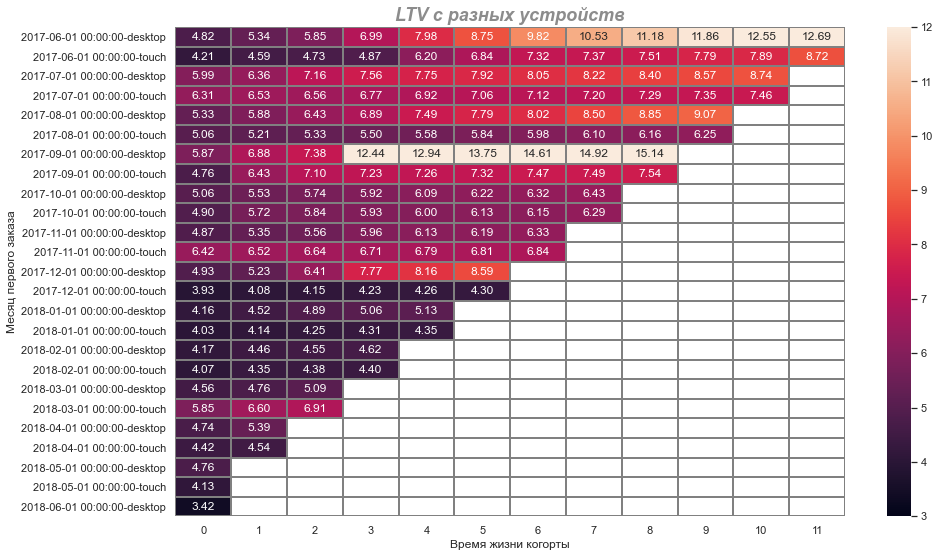

In [101]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('LTV с разных устройств',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(ltv_device, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin = 3, vmax = 12)
plt.xlabel('Время жизни когорты')
plt.ylabel('Месяц первого заказа')

LTV с ПК больше, чем с мобильных устройств

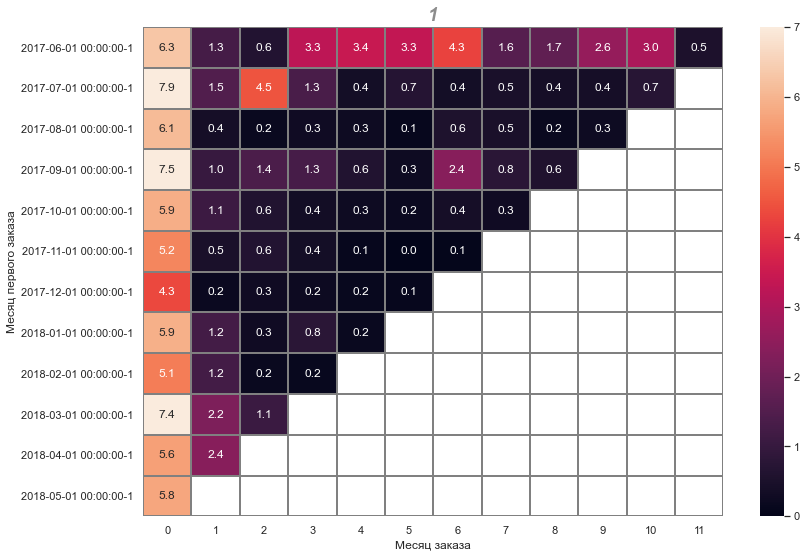

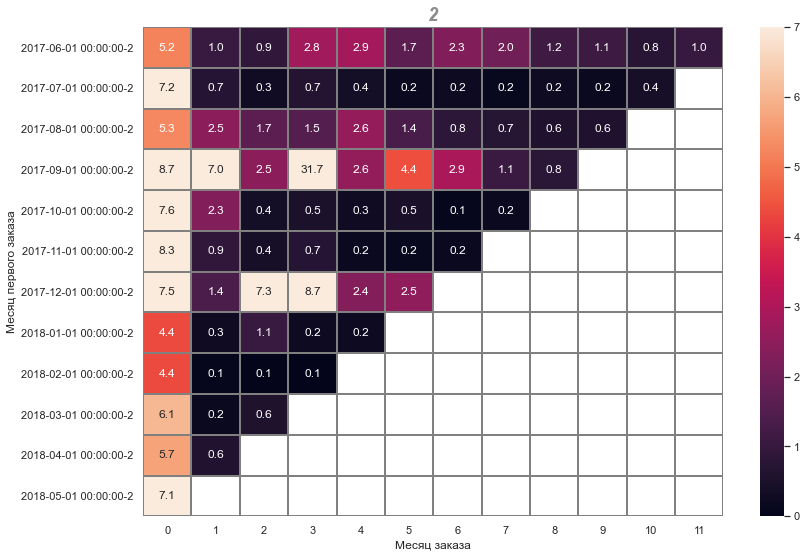

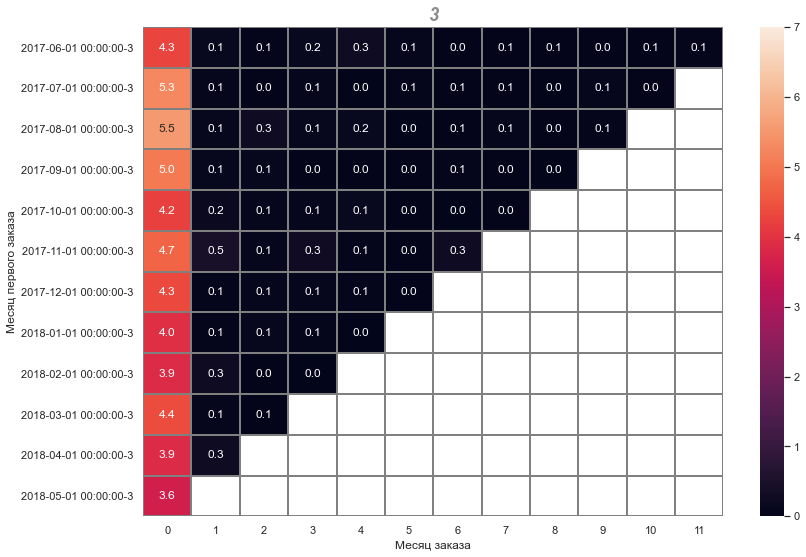

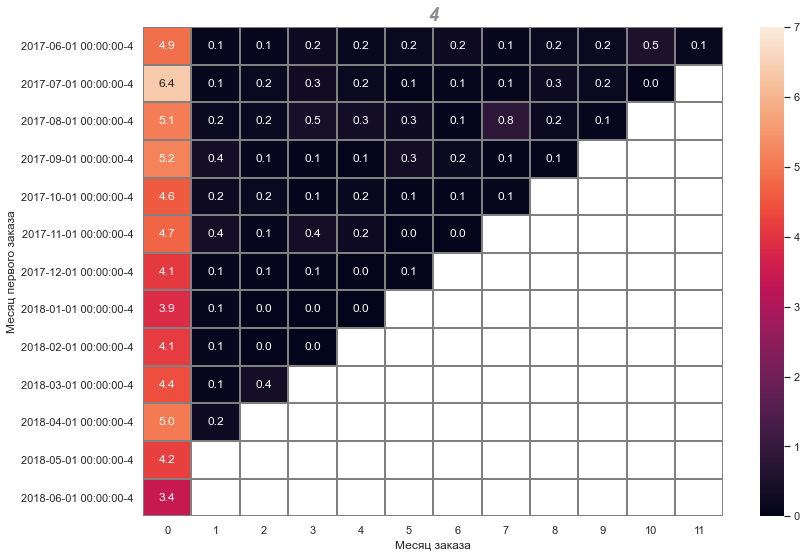

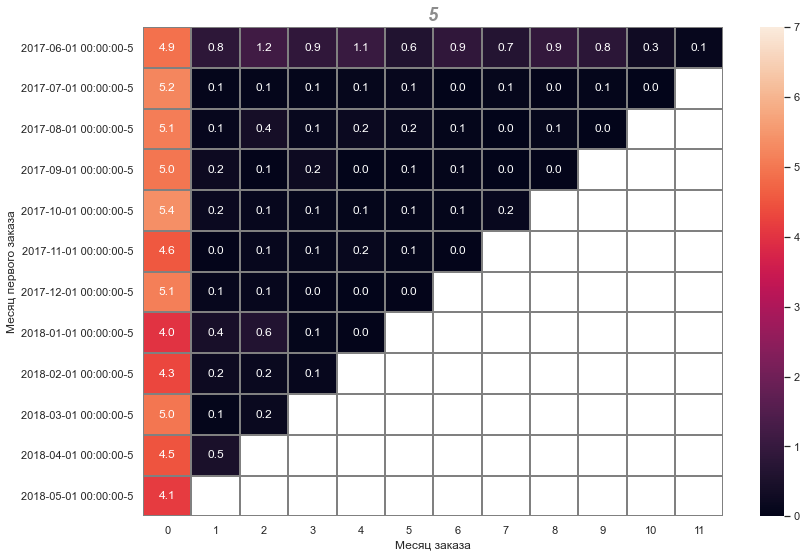

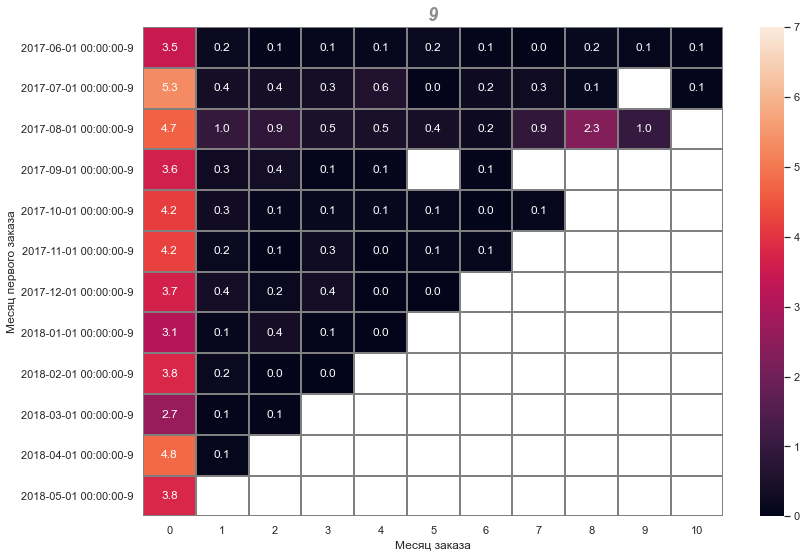

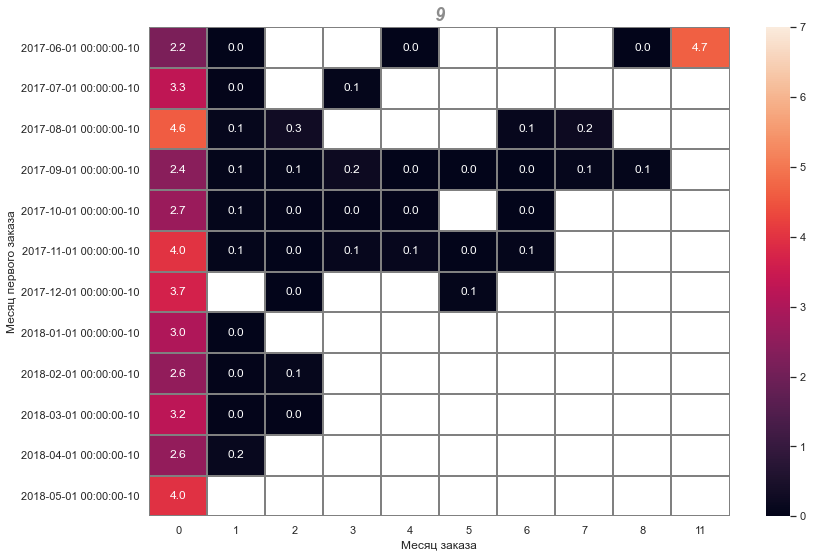

In [102]:
i = 0
ltv_mean = []

for i in range (len(orders['source_id'].unique()) - 2):
    cohorts_orders_source_count = orders.loc[orders['source_id'] == i+1].groupby(['first_order_month','source_id']).agg({'uid':'nunique'})
    cohorts_orders_source_sum = orders.loc[orders['source_id'] == i+1].pivot_table(index = ['first_order_month','source_id'], values = 'revenue', columns = 'cohort_lifetime', aggfunc = 'sum')
    k=0
        
    for k in range(0, 12):
        cohorts_orders_source_sum[k] = cohorts_orders_source_sum[k] / cohorts_orders_source_count['uid']
        

        
    
    ltv_source = cohorts_orders_source_sum 
    #ltv_mean.append(ltv_source.mean().mean())


    
    sns.set(style='white')
    plt.figure(figsize=(13, 9))
    plt.title(i+1,  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
    sns.heatmap(ltv_source, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin = 0, vmax = 7)
    plt.xlabel('Месяц заказа')
    plt.ylabel('Месяц первого заказа')
    plt.show()


    
cohorts_orders_source_count = orders.loc[orders['source_id'] == 9].groupby(['first_order_month','source_id']).agg({'uid':'nunique'})
cohorts_orders_source_sum = orders.loc[orders['source_id'] == 9].pivot_table(index = ['first_order_month','source_id'], values = 'revenue', columns = 'cohort_lifetime', aggfunc = 'sum')
l=0
for l in range(0, 11):
    cohorts_orders_source_sum[l] = cohorts_orders_source_sum[l] / cohorts_orders_source_count['uid']
        
    
ltv_source = cohorts_orders_source_sum 
#ltv_mean.append(ltv_source.mean())
    

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title(9,  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(ltv_source, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin = 0, vmax = 7)
plt.xlabel('Месяц заказа')
plt.ylabel('Месяц первого заказа')
plt.show()
    
cohorts_orders_source_count = orders.loc[orders['source_id'] == 10].groupby(['first_order_month','source_id']).agg({'uid':'nunique'})
cohorts_orders_source_sum = orders.loc[orders['source_id'] == 10].pivot_table(index = ['first_order_month','source_id'], values = 'revenue', columns = 'cohort_lifetime', aggfunc = 'sum')
l=0
for l in range(0, 9):
    cohorts_orders_source_sum[l] = cohorts_orders_source_sum[l] / cohorts_orders_source_count['uid']
        
    
ltv_source = cohorts_orders_source_sum 
#ltv_mean.append(ltv_source.mean().mean())
    

sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title(9,  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(ltv_source, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin = 0, vmax = 7)
plt.xlabel('Месяц заказа')
plt.ylabel('Месяц первого заказа')
plt.show()


Лучшие LTVs из источников 1,2

In [103]:
orders.head()

,buy_ts,revenue,uid,order_date,first_order_date,activity_month,source_id,device,start_ts,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,1,desktop,2017-06-01 00:09:00,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2,desktop,2017-06-01 00:14:00,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2,desktop,2017-06-01 00:25:00,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2,desktop,2017-06-01 00:14:00,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,3,desktop,2017-06-01 07:31:00,2017-06-01,0


In [104]:
cohorts_sources = orders.groupby(['first_order_month','cohort_lifetime', 'source_id']).agg({'revenue': 'sum'}).reset_index()
display(cohorts_sources.head()) 

,first_order_month,cohort_lifetime,source_id,revenue
0,2017-06-01,0,1,1260.83
1,2017-06-01,0,2,1394.14
2,2017-06-01,0,3,2396.61
3,2017-06-01,0,4,1983.27
4,2017-06-01,0,5,1803.73


In [105]:
cohort_sizes = orders.groupby(['first_order_month', 'source_id']).agg({'uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'source_id', 'n_buyers']
display(cohort_sizes.head()) 

,first_order_month,source_id,n_buyers
0,2017-06-01,1,200
1,2017-06-01,2,269
2,2017-06-01,3,559
3,2017-06-01,4,406
4,2017-06-01,5,368


In [106]:
orders_new = cohorts_sources.merge(cohort_sizes, on = ['first_order_month', 'source_id'])

In [107]:
orders_new['ltv'] = orders_new['revenue'] / orders_new['n_buyers']

In [108]:
orders_new

,first_order_month,cohort_lifetime,source_id,revenue,n_buyers,ltv
0,2017-06-01,0,1,1260.83,200,6.304150
1,2017-06-01,1,1,256.21,200,1.281050
2,2017-06-01,2,1,128.41,200,0.642050
3,2017-06-01,3,1,655.61,200,3.278050
4,2017-06-01,4,1,686.43,200,3.432150
...,...,...,...,...,...,...
508,2018-05-01,0,4,3052.70,728,4.193269
509,2018-05-01,0,5,2089.80,506,4.130040
510,2018-05-01,0,9,200.91,53,3.790755
511,2018-05-01,0,10,448.76,113,3.971327


### Маркетинг

Сколько денег потратили? Всего / на каждый источник / по времени

In [109]:
print('Потратили всего:', costs['costs'].sum())

Потратили всего: 329131.62


In [110]:
display(costs.head())

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


In [111]:
display(costs.pivot_table(index = 'source_id', values = 'costs', aggfunc = 'sum'))

,costs
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


<Figure size 432x288 with 0 Axes>

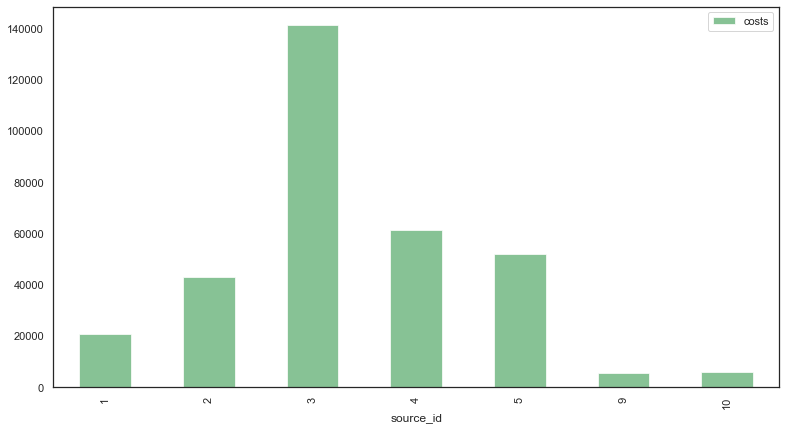

<Figure size 432x288 with 0 Axes>

In [112]:
costs.pivot_table(index = 'source_id', values = 'costs', aggfunc = 'sum').plot(kind = 'bar', color = 'g', alpha = 0.7, figsize = (13, 7))
plt.figure('Потраченные суммы на каждый источник')

In [113]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [114]:
display(costs.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum'))

,costs
month,
2017-06-01,18015.00
2017-07-01,18240.59
2017-08-01,14790.54
2017-09-01,24368.91
2017-10-01,36322.88
2017-11-01,37907.88
2017-12-01,38315.35
2018-01-01,33518.52
2018-02-01,32723.03


<AxesSubplot:xlabel='month'>

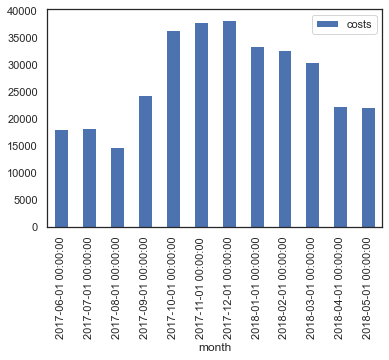

In [115]:
costs.pivot_table(index = 'month', values = 'costs', aggfunc = 'sum').plot(kind = 'bar')

In [116]:
display(costs.pivot_table(index = 'month', columns = 'source_id', values = 'costs', aggfunc = 'sum'))

source_id,1,2,3,4,5,9,10
month,,,,,,,
2017-06-01,1125.61,2427.38,7731.65,3514.80,2616.12,285.22,314.22
2017-07-01,1072.88,2333.11,7674.37,3529.73,2998.14,302.54,329.82
2017-08-01,951.81,1811.05,6143.54,3217.36,2185.28,248.93,232.57
2017-09-01,1502.01,2985.66,9963.55,5192.26,3849.14,415.62,460.67
2017-10-01,2315.75,4845.00,15737.24,6420.84,5767.40,609.41,627.24
2017-11-01,2445.16,5247.68,17025.34,5388.82,6325.34,683.18,792.36
2017-12-01,2341.20,4897.80,16219.52,7680.47,5872.52,657.98,645.86
2018-01-01,2186.18,4157.74,14808.78,5832.79,5371.52,547.16,614.35
2018-02-01,2204.48,4474.34,14228.56,5711.96,5071.31,551.50,480.88


Text(111.5, 0.5, 'источник')

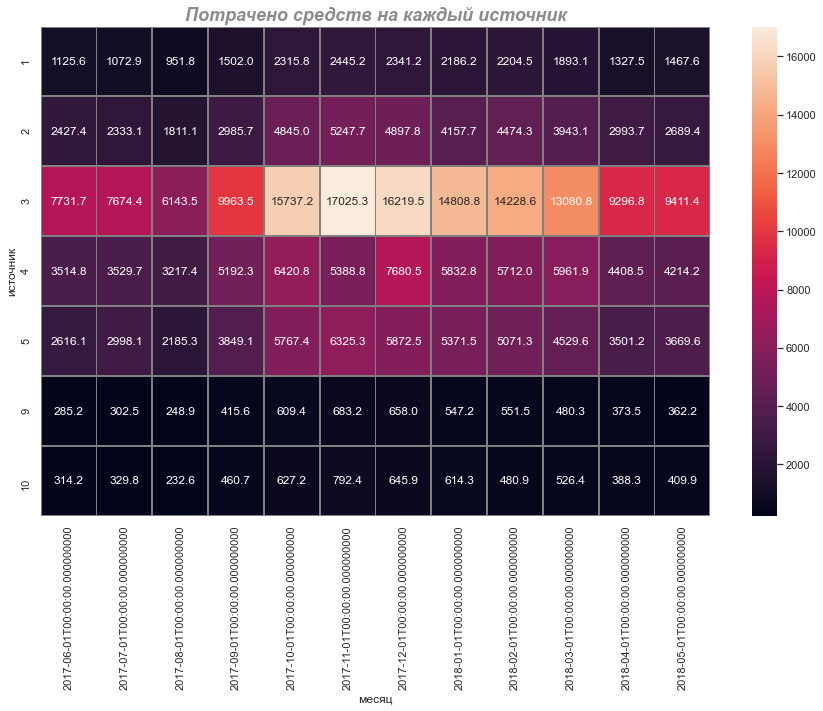

In [117]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Потрачено средств на каждый источник',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(costs.pivot_table(index = 'source_id', columns = 'month', values = 'costs', aggfunc = 'sum'), annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.xlabel('месяц')
plt.ylabel('источник')

Больше всего потрачено на источник 3

Сколько стоило привлечение одного покупателя из каждого источника?

In [118]:
display(orders.head())

,buy_ts,revenue,uid,order_date,first_order_date,activity_month,source_id,device,start_ts,first_order_month,cohort_lifetime
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,1,desktop,2017-06-01 00:09:00,2017-06-01,0
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2,desktop,2017-06-01 00:14:00,2017-06-01,0
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2,desktop,2017-06-01 00:25:00,2017-06-01,0
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2,desktop,2017-06-01 00:14:00,2017-06-01,0
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,3,desktop,2017-06-01 07:31:00,2017-06-01,0


In [119]:
orders['month'] = orders['activity_month']

In [120]:
users['dt'] = users['start_ts'].astype('datetime64[D]')

In [121]:
display(costs.head())

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [122]:

cac = costs.pivot_table(index = 'source_id', columns = 'month', values = 'costs', aggfunc = 'sum') / orders.pivot_table(
index = 'source_id', columns = 'first_order_month', values = 'uid', aggfunc = 'nunique')

In [123]:
display(cac)

,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01,2018-03-01,2018-04-01,2018-05-01,2018-06-01
source_id,,,,,,,,,,,,,
1,5.628050,5.084739,7.265725,5.251783,5.789375,5.569841,5.111790,6.355174,6.502891,5.617478,5.554351,4.703878,NaN
2,9.023717,9.484187,12.320068,9.789049,10.200000,10.495360,9.954878,12.599212,12.224973,10.322356,12.269262,6.182621,NaN
3,13.831216,17.481481,20.755203,15.790095,15.596868,17.179960,14.948866,18.282444,14.899016,15.855576,18.017074,12.582112,NaN
4,8.657143,7.233053,9.930123,9.222487,5.912376,4.930302,6.213972,6.107634,5.694875,6.158957,6.909859,5.788750,NaN
5,7.109022,7.707301,6.723938,6.705819,6.323904,9.761327,8.201844,8.622022,7.672179,8.235673,8.316271,7.252095,NaN
9,3.034255,4.201944,2.963452,4.284742,3.584765,3.795444,3.916548,4.929369,4.880531,2.582204,8.488409,6.833396,NaN
10,3.611724,7.170000,6.120263,6.581000,3.372258,7.405234,8.727838,7.313690,3.974215,3.025345,3.733173,3.627080,NaN


Text(111.5, 0.5, 'источник')

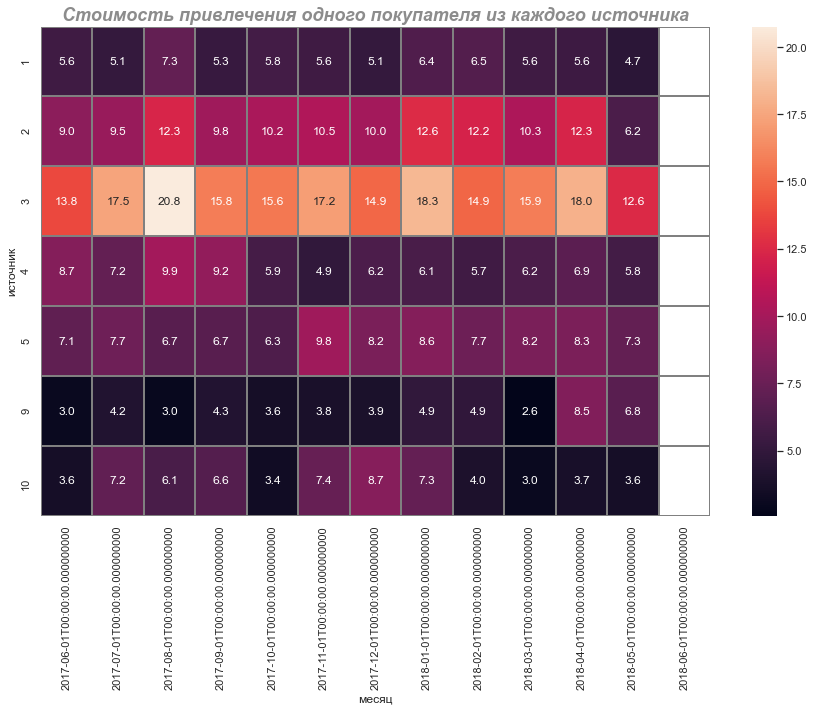

In [124]:
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('Стоимость привлечения одного покупателя из каждого источникa',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(cac, annot=True, fmt='.1f', linewidths=1, linecolor='gray')
plt.xlabel('месяц')
plt.ylabel('источник')


3 - самый дорогой источник

На сколько окупились расходы?

In [125]:
costs['month'] = costs['dt'].astype('datetime64[M]')

In [126]:
monthly_costs = costs.groupby(['month', 'source_id']).sum().reset_index()


In [127]:
monthly_costs

,month,source_id,costs
0,2017-06-01,1,1125.61
1,2017-06-01,2,2427.38
2,2017-06-01,3,7731.65
3,2017-06-01,4,3514.80
4,2017-06-01,5,2616.12
...,...,...,...
79,2018-05-01,3,9411.42
80,2018-05-01,4,4214.21
81,2018-05-01,5,3669.56
82,2018-05-01,9,362.17


In [128]:
orders_new = pd.merge(orders_new, monthly_costs, left_on=['first_order_month', 'source_id'], right_on=['month', 'source_id'])
orders_new['cac'] = orders_new['costs'] / orders_new['n_buyers']


In [129]:
orders_new['romi'] = orders_new['ltv'] / orders_new['cac']

In [130]:
romi = orders_new.pivot_table(index=['first_order_month', 'source_id'], columns='cohort_lifetime', values='romi', aggfunc='mean')

romi = romi.cumsum(axis=1).round(2) 

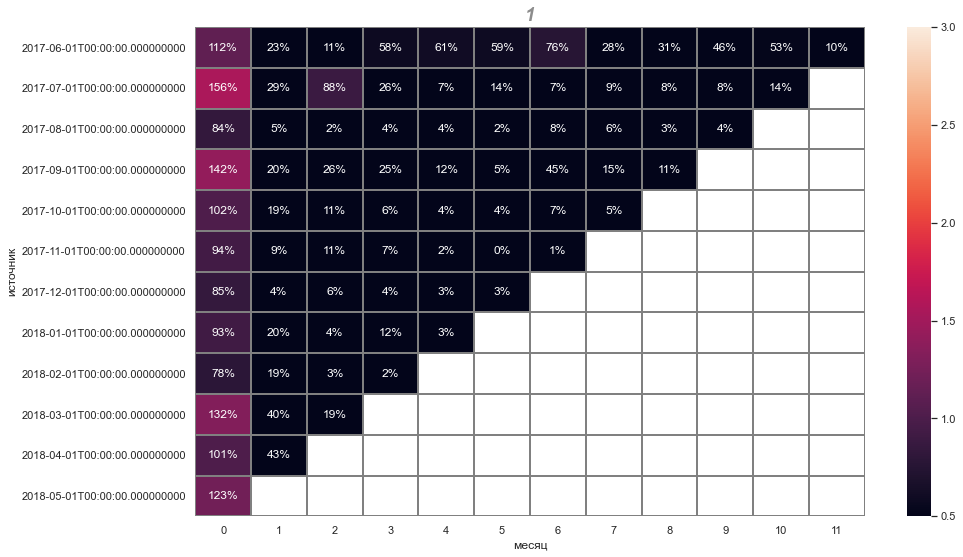

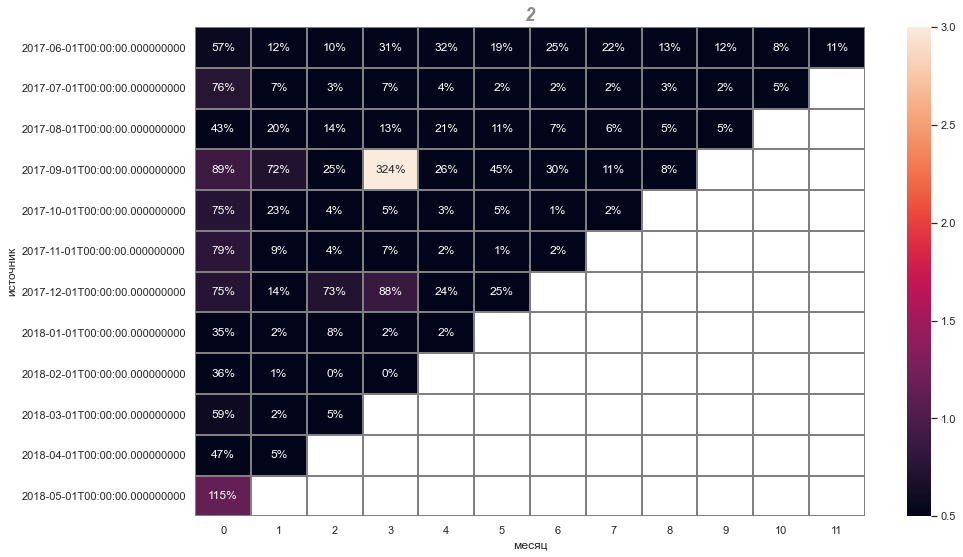

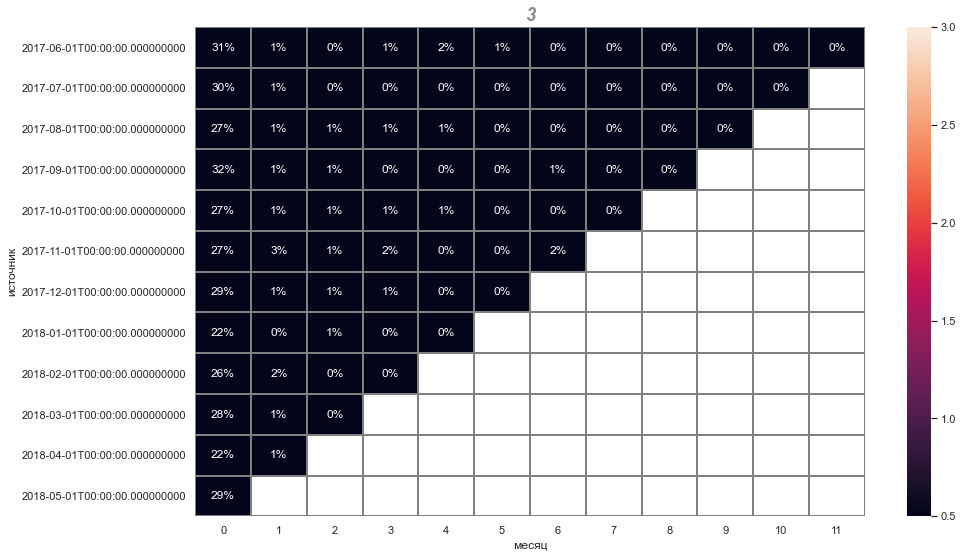

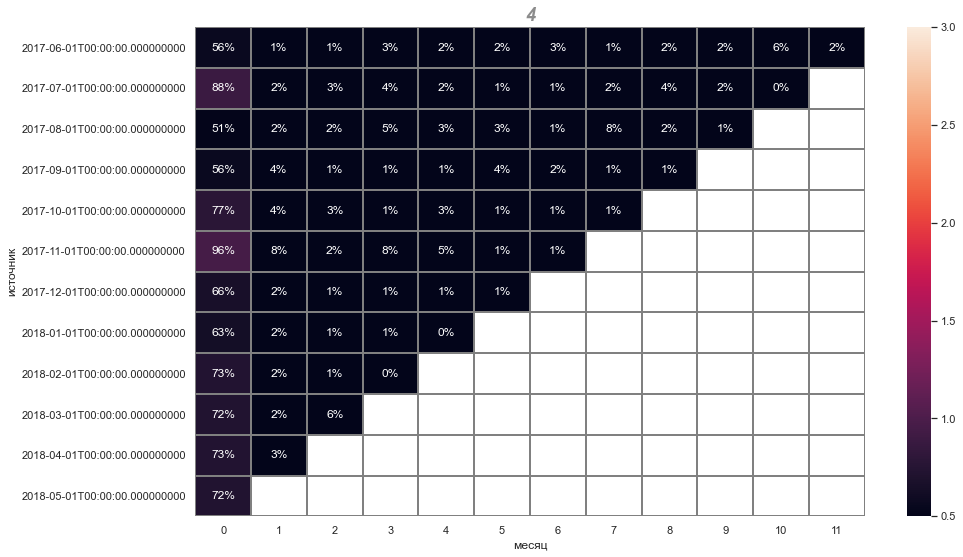

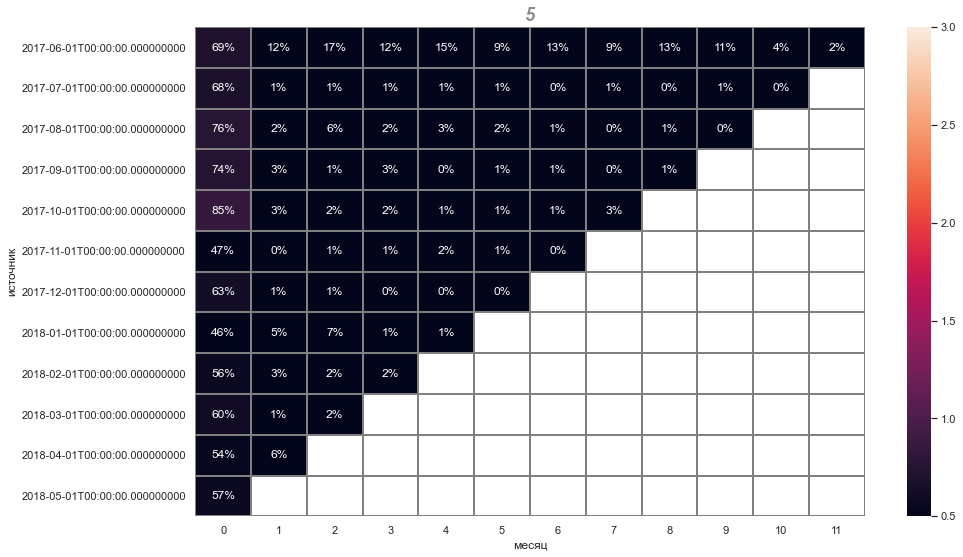

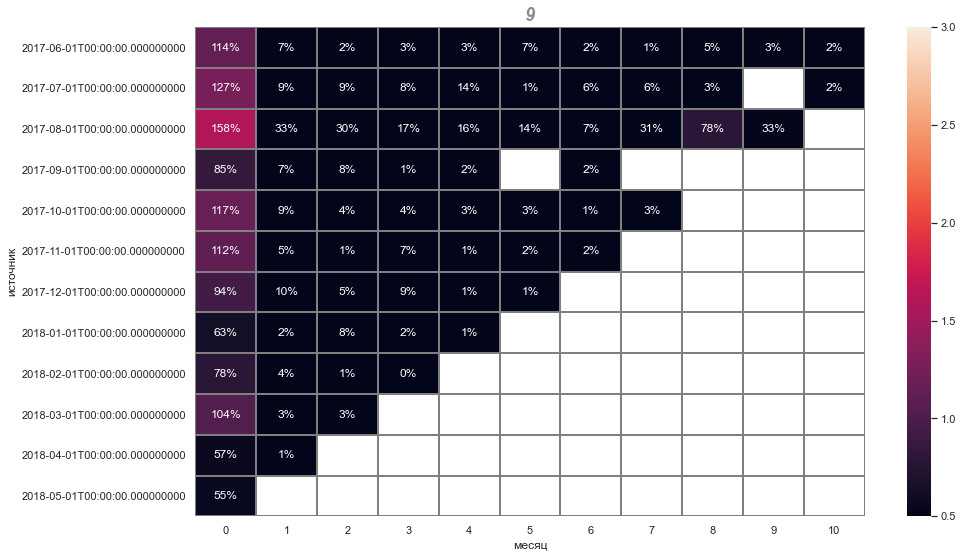

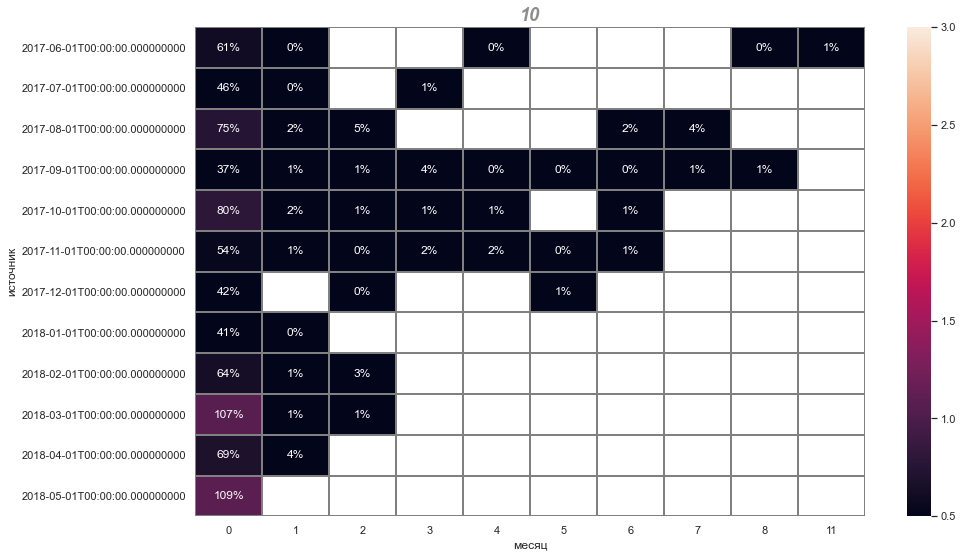

In [131]:
n=0
for n in range (len(orders['source_id'].unique()) - 2):
    romi = orders_new.loc[orders_new['source_id']==n+1].pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'romi', aggfunc = 'mean')
    romi.cumsum(axis=1).round(2) 
    sns.set(style='white')
    plt.figure(figsize=(15, 9))
    plt.title(n+1,  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
    sns.heatmap(romi, annot=True, fmt='.0%', linewidths=1, linecolor='gray', vmin = 0.5, vmax = 3)
    plt.xlabel('месяц')
    plt.ylabel('источник')
    plt.show()
    
romi = orders_new.loc[orders_new['source_id']==9].pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'romi', aggfunc = 'mean')
romi.cumsum(axis=1).round(2) 
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('9',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(romi, annot=True, fmt='.0%', linewidths=1, linecolor='gray', vmin = 0.5, vmax = 3)
plt.xlabel('месяц')
plt.ylabel('источник')
plt.show()

romi = orders_new.loc[orders_new['source_id']==10].pivot_table(index = 'first_order_month', columns = 'cohort_lifetime', values = 'romi', aggfunc = 'mean')
romi.cumsum(axis=1).round(2) 
sns.set(style='white')
plt.figure(figsize=(15, 9))
plt.title('10',  alpha=0.5, color="k", fontsize=18, fontstyle="italic", fontweight="bold", linespacing=10)
sns.heatmap(romi, annot=True, fmt='.0%', linewidths=1, linecolor='gray', vmin = 0.5, vmax = 3)
plt.xlabel('месяц')
plt.ylabel('источник')
plt.show()

с 1го месяца окупается только источник 1, почти окупается источник 9.
Изза низкого RR по когортам окупаемость после первого месяца заказа в когорте слабая

## Общий вывод

### Продукт

- Количество использований 
   - Количество использований в день: 907
   - Количество использовний в неделю: 5716
   - Количество использований в месяц: 23228
   
     Посещений с ПК больше, чем с мобильный устройств; из источников 3,4,5 больше, чем из остальных


- Количество сессий в день 
    - Среднее количество сессий в день: 1.08
    
    
- Продолжительность сессий
    - Самая частая продолжительность сессии - 60 секунд
    - На ПК сессии более продолжительны, чем на мобильных устройствах
    - Из источника 1 самые длительные сессии
    
    
- Retention rate
    - RR невысокий - от 7& до 2%
    - RR примерно одинаковый для пользователей ПК и моб устройств
    - Хороший RR из источников 1, 2 и 9
    
    
### Продажи

- Скорость покупки 
    - В среднем покупка происходит через 60 секунд после захода на сайт
    
- Количество покупок в месяц
    - В среднем пользователи делают 3878 заказа в месяц
    - С ПК заказов больше, чем с моб устройств
    - Больше всего заказов из источников 3, 4 и 5, источники 9 и 10 отстают
    
- Средний чек
    - Средний чек 4.75
    - Средний чек с ПК почти всегда выше, чем с мобильных устройств
    - Большие средние чеки из источников 1 и 2
    
- LTV
    - Разброс по когортам - от 4.25 до 14.77
    - LTV с ПК больше, чем с мобильных устройств
    - Лучшие LTVs из источников 1,2


### Маркетинг


- Сколько денег потратили? 
    - Потратили всего: 329131.62
    - Больше всего потратила на источник 3
    - Самые большие вложения были в октября, ноябре и декабре 2017
    
    
- САС
    - В среднем привлечение одного покупателя стоит 1.88
    - 1, 2 и 3 - самые дорогие источники за покупателя 
    
    
- ROMI
    - Самый дорогой источник (3) не окупается. Источники 1, 2 и 9 лучшие по окупаемости

- По всем метрикам лидирует ПК - возможно, нужно улучшить работу и удобство мобильной версии
- По источникам:
   - Источники 6, 7, 8 не работают
   - Источник 3 приносит много заказов, но не окупается и RR у него небольшой
   - Лучшие по всем метрикам - источники 1 и 9
- Стоит как-то завлечь старых пользователей, так как RR низкий 